# Train and test a machine learning classifier based on labeled tweets

The objective for this notebook is to classify all tweets as either being for or against the Mayor of London and to then classify users as being for or against based on how the majority of their tweets have been classified.

It takes the hashtags as a starting point and then labels any tweets with those hashtags as for or against
It then creates a subset of tweets containing for and against
- note: weren't sufficient for, so had to randomly select to create a balanced dataset
It then uses NLTK bag of words to produce top words and bigrams in the refined twitter message text
- I removed words from body if they were originally one of the hashtags used to classify the tweets - would skew results otherwise
It then uses NLTK count vectorizer to turn the words into features
- cannot use words in machine learning so create a column for each top word or bigram and then set value = 0 or 1 if that word or bigram exists within the tweet
- then train and test a classifier under different combinations of words, bigrams and number of features
    - just words, just bigrams, words and bigrams
    - 50 top words/bigrams, 100 top words/bigrams
- assess results
    - use feature importance to see which words, bigrams most important in deciding the classifier
    - collate simple stats showing the proportion of each of these words in for and against classes
    
For best combination of words, bigrams and number of each, use grid search to get optimal hyperparameter to train a classifier that is generalisable to unseen data

Use this classifier to predict classifications for remaining tweet dataset
- remaining tweet dataset will be those tweets not used in training or testing the classifier

Then merge the classified tweets with tweets previously labeled to create a single dataset, which we export for use in downstream processes

The logic is summarised in the schematic below.
- It should be noted that we do did into different analysis as we perform each step in order to assess what we've found. For example, having identified for and against tweets we then look at most popular words and bigrams for them

<img src="notebook_logic_schematic_1_9.png">


## Notes:
In this notebook we exclude retweets because the words and bigrams used in an oft retweeted tweet are given undue weight in the corpus and vectorized features by virtue of the number of times they are used. This skews the results and so retweets are removed prior to performing our machine learning. However, we have kept a record of results using a classifier trained with retweets in order to illustrate the effect (this is provided within the notebook 1_9_b).

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
all_tweets_original = pd.read_csv("./DataSources/TwitterData/cleaned_tweets.csv")
print(all_tweets_original.shape)
display(all_tweets_original.head())
display(all_tweets_original.tail())

(41706, 26)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,...,[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,2021-07-28 00:00:00
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,...,['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,2021-07-28 00:00:00
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,2021-07-28 00:00:00
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,...,[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,2021-07-28 00:00:00
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,2021-07-28 00:00:00


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
41701,41701,1428283084219330566,2021-08-19 09:09:58,872173973785673728,jim._.price75,jimprice75,"Sheffield, England",RT @suemitch2017: BREAKING: Police rush to sce...,NaN,NaN,...,[],[],BREAKING Police rush to scene of horror Londo...,"['breaking', 'police', 'rush', 'to', 'scene', ...","['breaking', 'police', 'rush', 'scene', 'horro...","['breaking', 'police', 'rush', 'scene', 'horro...",breaking police rush scene horror stabbing kni...,2021-08-19 09:09:58,2021-08-19 00:00:00,2021-08-19 00:00:00
41702,41702,1428234744450387968,2021-08-19 05:57:53,985978695860019200,Dianne mary,Diannebrown128,unknown,RT @suemitch2017: BREAKING: Police rush to sce...,NaN,NaN,...,[],[],BREAKING Police rush to scene of horror Londo...,"['breaking', 'police', 'rush', 'to', 'scene', ...","['breaking', 'police', 'rush', 'scene', 'horro...","['breaking', 'police', 'rush', 'scene', 'horro...",breaking police rush scene horror stabbing kni...,2021-08-19 05:57:53,2021-08-19 00:00:00,2021-08-19 00:00:00
41703,41703,1428127105179688962,2021-08-18 22:50:09,1226457400812736512,"AnnMorton,",AnnMort92883429,unknown,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,...,[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-18 22:50:09,2021-08-18 12:00:00,2021-08-18 00:00:00
41704,41704,1428100984920846336,2021-08-18 21:06:22,1388101054336749570,John Green,john_f_green,"London, England",Yet another stabbing in #london 😧https://t.co...,NaN,NaN,...,[],['#london'],Yet another stabbing in london 😧,"['yet', 'another', 'stabbing', 'in', 'london',...","['yet', 'another', 'stabbing', '😧']","['yet', 'another', 'stabbing', '😧']",yet another stabbing 😧,2021-08-18 21:06:22,2021-08-18 12:00:00,2021-08-18 00:00:00
41705,41705,1428007860609421327,2021-08-18 14:56:19,2728878058,Maria,MariaEW100,Worcester,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,...,[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-18 14:56:19,2021-08-18 12:00:00,2021-08-18 00:00:00


In [9]:
hashtags = pd.read_csv("./DataSources/TwitterData/important_hashtags.csv")
print(hashtags.shape)
hashtags

display(hashtags.sort_values(by=['community_id', 'class_label'], ascending=True)[:40])
display(hashtags.sort_values(by=['community_id', 'class_label'], ascending=True)[40:])

(70, 3)


,hashtag,class_label,community_id
20,#harrow,AGAINST,0
23,#knifecrime,AGAINST,0
34,#khanage,AGAINST,0
55,#stop,AGAINST,0
62,#orpington,AGAINST,0
65,#violentcrime,AGAINST,0
67,#southlondon,AGAINST,0
68,#wokemadness,AGAINST,0
48,#austerity,FOR,0
49,#beatingcrimeplan,FOR,0


,hashtag,class_label,community_id
61,#fiction,AGAINST,2
63,#th,AGAINST,2
8,#arrested,AGAINST,3
12,#stabbed,AGAINST,3
35,#boys,AGAINST,3
36,#chingford,AGAINST,3
37,#death,AGAINST,3
38,#man,AGAINST,3
39,#eveningstandard,AGAINST,3
40,#found,AGAINST,3


## Comment on hashtags and proposed changes
- community=0: all the 'FOR' class labels fall within this community and its correct they're clustered together, particularly given this includes all the 'FOR' seed words. However, this community also contains some of the strongest AGAINST hashtags, including #knifecrime and #khanage which were among the seed words for the AGAINST classification. Maybe this community reflects the strength of the hashtags rather than their opinion but in any case do not change the class label of any of these hashtags as they seem appropriate. 
- community=1: some of these hashtags relate to a novel (judaspig) and the rest aren't really one class or another so remove except for #hydepark, #policeappeal and #police. Leave them in place as AGAINST for now. 
- community=2: keep #arrest, #charges and #crime as AGAINST but remove remaining labels as many are related to a crime/thriller director (Basil Dearden)
- community=3: definitely relevant, leave as AGAINST for now, maybe revisit
- community=4: AGAINST is a reasonable class label but remove #live and #freespeech as seem less relevant
- community=5: for some reason there is no community with value = 5
- community=6: AGAINST is a reasonable class label but remove #football and #english as too generic

In [10]:
hashtags_to_remove = ['#judaspig',
                     '#brutally',
                     '#london',
                     '#eastlondon',
                     '#gangster',
                     '#judaspig',
                     '#anonymousprotectingchildrens',
                     '#hacker',
                     '#labourparty',
                     '#officer',
                     '#workfromhome',
                     '#villain',
                     '#basildearden',
                     '#eunat',
                     '#eu',
                     '#huge',
                     '#list',
                     '#law',
                     '#fiction',
                     '#th',
                     '#live',
                     '#english',
                     '#football',
                     '#freespeech',
                     ]

hashtags_clean = hashtags[~hashtags.hashtag.isin(hashtags_to_remove)].copy()

hashtags_clean.sort_values(by=['class_label', 'community_id'], ascending=False)

,hashtag,class_label,community_id
48,#austerity,FOR,0
49,#beatingcrimeplan,FOR,0
50,#borisjohnson,FOR,0
51,#policecuts,FOR,0
52,#racism,FOR,0
53,#stopandsearch,FOR,0
54,#racistengland,FOR,0
25,#sadiqkhan,AGAINST,6
27,#londonmayor,AGAINST,6
66,#woke,AGAINST,6


## Now classify tweets according to which class the majority of their hashtags fall into

In [11]:
for_hashtags = hashtags_clean['hashtag'][hashtags_clean.class_label == 'FOR'].to_list()
against_hashtags = hashtags_clean['hashtag'][hashtags_clean.class_label == 'AGAINST'].to_list()

set_for = set(for_hashtags)
set_against = set(against_hashtags)

### Comparing hashtags
I will be comparing the hashtags within a single tweet with the for and against hashtag lists and summing the number of matches to identify whether the tweet is predominately for or against the mayor. I will use pandas 'sets' and its difference function to do this. This was inspired by https://www.stechies.com/compare-lists-python-using-set-cmp-function/

In Appendix A we test the following functions with dummy data to prove they work as expected

However, first we want to limit the dataset to original tweets i.e. exclude retweets.

#### exclude retweets

In [12]:
display(all_tweets_original.shape)
all_tweets = all_tweets_original[all_tweets_original.is_retweet == 'N'].copy().reset_index()
display(all_tweets.shape)
display(all_tweets.head())
display(all_tweets.tail())

(41706, 26)

(11873, 27)

,level_0,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
0,5,5,1420349249661853697,2021-07-28 11:43:44,1338186814448922625,Oliver Steinmetz,OliverSteinme16,unknown,@Bravescott69 @Kalimeralynn I am totally agree...,Bravescott69,...,"['@Bravescott69', '@Kalimeralynn']",[],I am totally agree with him that Khan must a...,"['i', 'am', 'totally', 'agree', 'with', 'him',...","['totally', 'agree', 'khan', 'act', 'crackdown...","['totally', 'agree', 'khan', 'act', 'crackdown...",totally agree khan act crackdown knife crime r...,2021-07-28 11:43:44,2021-07-28 00:00:00,2021-07-28 00:00:00
1,8,8,1420345735799791620,2021-07-28 11:29:46,257934901,Eilidh,bramble__jam,Dublin,A lot of the time when non-londonders make lit...,NaN,...,[],[],A lot of the time when nonlondonders make litt...,"['a', 'lot', 'of', 'the', 'time', 'when', 'non...","['lot', 'time', 'nonlondonders', 'make', 'litt...","['lot', 'time', 'nonlondonders', 'make', 'litt...",lot time nonlondonders make little jokes knife...,2021-07-28 11:29:46,2021-07-28 00:00:00,2021-07-28 00:00:00
2,10,10,1420345177911267330,2021-07-28 11:27:33,1359171603205128194,Daniel Cindrem,John27454952,unknown,@linmeitalks Let's be honest. The majority of ...,linmeitalks,...,['@linmeitalks'],[],Lets be honest The majority of knife crime in...,"['lets', 'be', 'honest', 'the', 'majority', 'o...","['lets', 'honest', 'majority', 'knife', 'crime...","['lets', 'honest', 'majority', 'knife', 'crime...",lets honest majority knife crime committed bla...,2021-07-28 11:27:33,2021-07-28 00:00:00,2021-07-28 00:00:00
3,21,21,1420339262516563970,2021-07-28 11:04:03,706903864,mrsthatcher,527_thatch,"Brighton, England",Most of the Country think you should concentra...,NaN,...,[],[],Most of the Country think you should concentra...,"['most', 'of', 'the', 'country', 'think', 'you...","['country', 'think', 'concentrate', 'ending', ...","['country', 'think', 'concentrate', 'ending', ...",country think concentrate ending knife crime s...,2021-07-28 11:04:03,2021-07-28 00:00:00,2021-07-28 00:00:00
4,25,25,1420338014031654913,2021-07-28 10:59:05,1113121490315198466,CallyJ,Short2Cjs,unknown,Boris today speaking to Nick Ferrari about Kha...,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kha...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 10:59:05,2021-07-28 00:00:00,2021-07-28 00:00:00


,level_0,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
11868,41669,41669,1429022268143947776,2021-08-21 10:07:13,1425537126704324610,Recharge⚡,7_recharge,UK,@DeclandThomas06 @stephenkeane233 @TheReal0363...,DeclandThomas06,...,"['@DeclandThomas06', '@stephenkeane233', '@The...",[],The public is London is now well know as a...,"['the', 'public', 'is', 'london', 'is', 'now',...","['public', 'well', 'know', 'stabbing…']","['public', 'well', 'know', 'stabbing…']",public well know stabbing…,2021-08-21 10:07:13,2021-08-21 00:00:00,2021-08-21 00:00:00
11869,41672,41672,1429016036800704513,2021-08-21 09:42:27,2189056412,Commodity Hunter #MBGA,BermudaBat,"England, United Kingdom",The #Khanage continues..\n\nLondon murder prob...,NaN,...,[],['#khanage'],The Khanage continues\n\nLondon murder probe a...,"['the', 'khanage', 'continues', 'london', 'mur...","['khanage', 'continues', 'murder', 'probe', 's...","['khanage', 'continues', 'murder', 'probe', 's...",khanage continues murder probe stabbed chest b...,2021-08-21 09:42:27,2021-08-21 00:00:00,2021-08-21 00:00:00
11870,41673,41673,1429013785965105152,2021-08-21 09:33:31,590147379,UK News in Pictures (@UKNIP247),uknip247,United Kingdom,"Police were called at 3.45am on Saturday, 21 A...",NaN,...,[],[],Police were called at am on Saturday August t...,"['police', 'were', 'called', 'at', 'am', 'on',...","['police', 'called', 'saturday', 'august', 're...","['police', 'called', 'saturday', 'august', 're...",police called saturday august reports disturba...,2021-08-21 09:33:31,2021-08-21 00:00:00,2021-08-21 00:00:00
11871,41677,41677,1428972448733614080,2021-08-21 06:49:15,198818760,Cristian Nord,CristianNord,..RSA..,man stabbed for hat and bag during terrifying ...,NaN,...,[],['#london'],man stabbed for hat and bag during terrifying ...,"['man', 'stabbed', 'for', 'hat', 'and', 'bag',...","['stabbed', 'hat', 'bag', 'terrifying', 'attac...","['stabbed', 'hat', 'bag', 'terrifying', 'attac...",stabbed hat bag terrifying attack tube station...,2021-08-21 06:49:15,2021-08-21 00:00:00,2021-08-21 00:00:00
11872,41704,41704,1428100984920846336,2021-08-18 21:06:22,1388101054336749570,John Green,john_f_green,"London, England",Yet another stabbing in #london 😧https://t.co...,NaN,...,[],['#london'],Yet another stabbing in london 😧,"['yet', 'another', 'stabbing', 'in', 'london',...","['yet', 'another', 'stabbing', '😧']","['yet', 'another', 'stabbing', '😧']",yet another stabbing 😧,2021-08-18 21:06:22,2021-08-18 12:00:00,2021-08-18 00:00:00


#### Comments on removing retweets
Removing retweets reduces the original dataset by nearly 75% so we are left with just 12,000 tweets.

In [13]:
def string_to_list(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_list = my_str.split(delimiter)
    return my_list

def get_tweet_class(hashtags, set_for, set_against):

    class_value = 'NONE'
    
    if len(hashtags) > 2 : # a tweet with no hashtags contains [] and so len==2 means no hashtags
        
        class_value = 'HAS_HASHTAG'
        
        hashtags_in_tweet = string_to_list(hashtags)
        set_hashtags = set(hashtags_in_tweet)

        # take intersections of two lists                
        for_test = set_for.intersection(set_hashtags)
        against_test = set_against.intersection(set_hashtags)
    
        # check if any matches with our for/against lists 
        if (len(against_test) > 0) | (len(for_test) > 0):
                        
            #there is at least one match, now test which matches more closely
            if len(against_test) > len(for_test):
                class_value = 'AGAINST'
            else:
                class_value = 'FOR'
        
    return class_value

In [14]:
all_tweets['label'] = '' 
all_tweets['label'] = all_tweets['hashtags'].apply(lambda x: get_tweet_class(x, set_for, set_against))

all_tweets_count = all_tweets['label'].count()
for_count = all_tweets['label'][all_tweets.label == 'FOR'].count()
for_pct = for_count / all_tweets_count
against_count = all_tweets['label'][all_tweets.label == 'AGAINST'].count()
against_pct = against_count / all_tweets_count
other_tag_count = all_tweets['label'][all_tweets.label == 'HAS_HASHTAG'].count()
other_tag_pct = other_tag_count / all_tweets_count

print("Out of a total of {:,} tweets, we have the following classifications:\nAGAINST: {} ({:.1%})\nFOR: {} ({:.1%})\nOther Hashtag: {} ({:.1%})".format(all_tweets_count, 
                                                                                                                                        against_count, against_pct, 
                                                                                                                                        for_count, for_pct,
                                                                                                                                        other_tag_count, other_tag_pct))

Out of a total of 11,873 tweets, we have the following classifications:
AGAINST: 210 (1.8%)
FOR: 13 (0.1%)
Other Hashtag: 699 (5.9%)


### Comments 
It tells us something that more than 10 times the hashtags are against the Mayors evidence but having just 5.9% of tweets containing hashtags and only around 2% containing hashtags with which we can classify our tweeters is not a great return.

This is because the objectiuve for this exercise is to use hashtags as a means to classify tweet sentiment and, as discussed by Bovet, large usage of opinion hashtags (and polarisation of their usage) are strong pre conditions for their method being successful.

We have around 200 tweets in the AGAINST class but too few in the FOR class to be able to use these tweets on their own as the basis for the other label in our classification. We could use SMOTE as we did previously but oversampling less than 20 tweets dramatically increases the likelyhood of an overfitted model. We therefore propose creating the FOR tweets by taking all FOR tweets plus a random sample of other tweets which have been labeled HAS_HASHTAG.  

Having created these datasets we will then analyse their content before progressing onto creating features as inputs to our classification model.

In [15]:
col_list = ['tweet_id',
           'tweeter_screen_name',
           'hashtags',
           'Tweet_lemmatized',
           'Clean_MessageText',
           'label']

against_tweets = all_tweets[col_list][all_tweets.label == 'AGAINST']
against_tweets['target'] = 1

# get all FOR tweets
for_tweets = all_tweets[col_list][all_tweets.label == 'FOR']
# now fill up with other hashtags
other_hashtag_count = against_count - for_count
other_hashtag_tweets = all_tweets[col_list][all_tweets.label == 'HAS_HASHTAG'].sample(n=other_hashtag_count)

frames = [for_tweets, other_hashtag_tweets]

not_against_tweets = pd.concat(frames)
not_against_tweets['target'] = 0

pruned_tweets = pd.concat([against_tweets, not_against_tweets]).reset_index(drop=True)
pruned_tweets.drop('label', axis=1, inplace=True)

print("against_count: {}, for_count: {}, other_hashtag_count: {}".format(against_count, for_count, other_hashtag_count))
print("pruned_tweets shape: {}".format(pruned_tweets.shape))
display(pruned_tweets.head())
display(pruned_tweets.tail())

against_count: 210, for_count: 13, other_hashtag_count: 197
pruned_tweets shape: (420, 6)


,tweet_id,tweeter_screen_name,hashtags,Tweet_lemmatized,Clean_MessageText,target
0,1419696027821481990,flyingeze,"['#crime', '#hortonandwellington', '#knife']","['seriously', 'injured', 'stabbing', 'teen', '...",seriously injured stabbing teen girl woman cha...,1
1,1419551117877338112,NEWSONE14898745,"['#sadiq', '#khan', '#knife', '#crime']","['’', 'six', 'years', '’', 'sadiq', 'khan', 'l...",’ six years ’ sadiq khan lambasted knife crime...,1
2,1418616885462110208,WembleyCrime,"['#knifecrime', '#london']","['knifecrime', 'fallen', 'low', 'total', 'five...",knifecrime fallen low total five years,1
3,1418324586681315331,BermudaBat,['#khanage'],"['’', 'six', 'years', '’', 'lambasted', 'knife...",’ six years ’ lambasted knife crime surge khan...,1
4,1418169421575639042,kss_ltd,"['#london', '#crime']","['crime', 'city', 'hit', 'night', 'violence', ...",crime city hit night violence leaving dead hos...,1


,tweet_id,tweeter_screen_name,hashtags,Tweet_lemmatized,Clean_MessageText,target
415,1429394168896491527,Foxmental_X,"['#lgbtq', '#lgbtrights', '#lgbtqequality', '#...","['arrested', 'suspicion', 'murdering', 'gay', ...",arrested suspicion murdering gay victim cemete...,0
416,1429594768049414144,MarkCam27389171,['#walthamforest'],"['walthamforest', 'breaking', 'yearold', 'rush...",walthamforest breaking yearold rushed eastlond...,0
417,1420865644308963333,blllabong,['#michaelgove'],"['’', 'think', 'moment', 'dominic', 'cummings'...",’ think moment dominic cummings gone principle...,0
418,1427306148890353665,got_motor,['#freejulianassange'],"['freejulianassange', 'held', 'solitary', 'con...",freejulianassange held solitary confinement hi...,0
419,1429178285431341059,Gindy,['#clapham'],"['police', 'appeal', 'raped', 'clapham', 'comm...",police appeal raped clapham common evening sta...,0


### Comments
Tweets with target = 0 should be tweets that aren't actively against the Mayor but the message text suggests otherwise and these tweets have be wrongly classified because classification is based on hashtags whereas these tweets don't contain hashtags and the sentiment is instead found within the message text itself.

This merits further investigation here, to identify key themes in the FOR and AGAINST camps

In [16]:
import twitter_NLP_functions as tw_nlp

Loading BokehJS ...


 ----------- ALL WORDS - FOR ---------- 



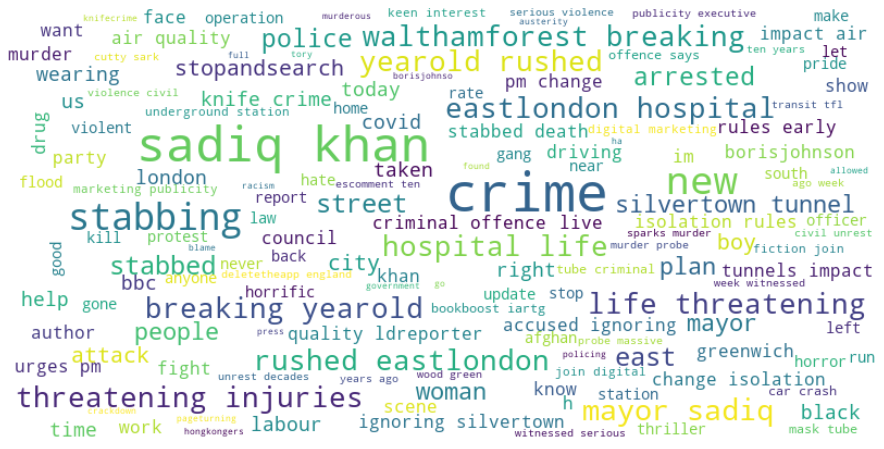


 ----------- ALL WORDS - AGAINST ---------- 



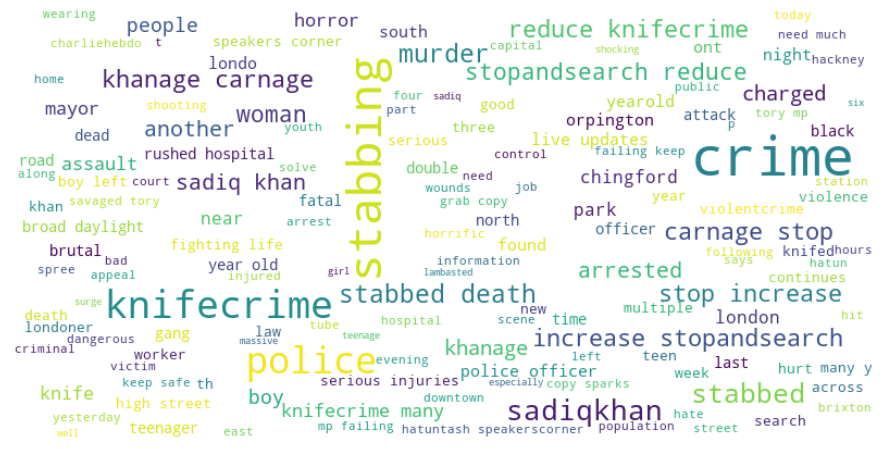

Number of words, FOR = 1223
Number of words, AGAINST = 982


In [17]:
all_clean_words_for = " ".join(ttext for ttext in pruned_tweets[pruned_tweets.target==0]['Clean_MessageText']) # code taken from VA_Lab08 (Text)
all_clean_words_against = " ".join(ttext for ttext in pruned_tweets[pruned_tweets.target==1]['Clean_MessageText']) # code taken from VA_Lab08 (Text)

tw_nlp.plot_wordcloud(all_clean_words_for, 'ALL WORDS - FOR')
tw_nlp.plot_wordcloud(all_clean_words_against, 'ALL WORDS - AGAINST')

unique_for = tw_nlp.unique_words(all_clean_words_for)
unique_against = tw_nlp.unique_words(all_clean_words_against)

print("Number of words, FOR = " + str(len(unique_for))) # we have 462922 unique words
print("Number of words, AGAINST = " + str(len(unique_against))) 

In [18]:
tw_nlp.plot_ngrams(pruned_tweets[pruned_tweets.target==0], 'Clean_MessageText')

In [19]:
tw_nlp.plot_ngrams(pruned_tweets[pruned_tweets.target==1], 'Clean_MessageText')

## Comments
Tweets within the FOR and AGAINST classes use very similar words in the body of the text and this means the features we create from them (bag of words, count vectorizer) will be similar too. Which will impact the performance of our classifier. This problem arisesd because less than 6% of our tweets contain any hashtags at all and less than 2% contained hashtags that we used to classify tweets.

Before progressing, it's worth double checking the words used in the message text of tweets which we'd originally classified as supporting the Mayor. This could help us understand whether our problem arises from having to randomly select tweets


 ----------- ALL WORDS - FOR, from hashtags ---------- 



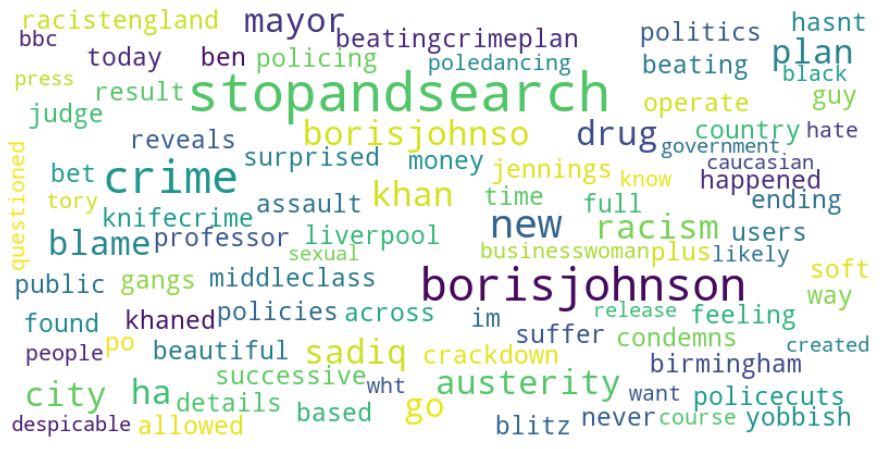

Number of words, FOR, from hashtags = 101


In [20]:
all_clean_words_for_hash = " ".join(ttext for ttext in all_tweets[all_tweets.label == 'FOR']['Clean_MessageText']) # code taken from VA_Lab08 (Text)

tw_nlp.plot_wordcloud(all_clean_words_for_hash, 'ALL WORDS - FOR, from hashtags')

unique_for_hash = tw_nlp.unique_words(all_clean_words_for_hash)

print("Number of words, FOR, from hashtags = " + str(len(unique_for_hash)))

In [21]:
tw_nlp.plot_ngrams(all_tweets[all_tweets.label == 'FOR'], 'Clean_MessageText')

We can see a difference in the words used in those classified as FOR tweets based on the hashtags. This suggests we could have had more success if we'd identified a greater number of tweets using hashtags which openly supported the Mayors position. This means that we confirm Bovet's original conclusion that for his classification process to work we need 'a large usage of opinion-hashtags and a polarization of opinion resulting in well seperated hashtag clusters'.

However, we want to complete the exercise to review the performance of our classifier to confirm this hypothesis. The first step is to create the features we will use to train the classification model.

Bovet used both hashtags (having first removed the cooccurring hashtags) and words within the tweet message text to generate features but we know that many most of our FOR tweets will not contain hashtags and so using them for the AGAINST tweets will bias our dataset. We will therefore purely concentrate on message body text.

However, it is <b>important that we remove from the message body text any hashtags that were used in labelling the tweets</b>. This is because leaving these hashtags skews the classification performance because we will have a one for one relationship between tweets containing these hashtags and the labels they were assigned. This is why we observed such amazing results when we erroneously missed this step, as is illustrated in the image below

<img src="tweet_labeling_ML_performance - erroneous.png">

### Create features ----> blah blah
Bovet used hashtags, we know a large number of our tweets don't contain them so just vectorize on the message text
- use vectoriser, bag of words, ngrams
- see how we get on in terms of accuracy

- then group tweets by tweeter id and class and use majority class to set opinion of tweeter
- see how many tweeters out of total we classify and therefore how many tweets out of 24,772

- compare this with what we got from community detection algorithms


### Bovet notebooks
https://github.com/alexbovet/network_lesson/blob/master/04_Twitter_Sentiment_Analysis.ipynb
https://github.com/alexbovet/network_lesson/blob/master/TwSentiment.py
https://github.com/alexbovet/network_lesson/blob/master/train_sentiment_classifier.py

### Create vocabularies containing top 50 words and ngrams
These will be used to constrain the results of the countvectorizer to mark the presence or absence of only the top 50 items
- otherwise it creates entries for every single word in the document corpus

<b> <---------- THESE RESULTS ARE WRONG, REPLACE ----------> </b>

Using 50 of each I got the following performance 
- prediction accuracy: 0.7801418439716312
- precision: 0.9339622641509434
- recall: 0.6428571428571429
- Area under the curve score: 0.7940848214285714

#### amendment - use top 100 ngrams and words
Using 100 of each I got the following performance
- prediction accuracy 0.8439716312056738
- precision 0.8928571428571429
- recall 0.8116883116883117
- Area under the curve score 0.8472504058441559

### Strip hashtags from message text
We need to be careful when stripping hashtags from clean message text because the message text could have contained the same words as used in a hashtag but as text on its own, rather than as a hashtag. Therefore, we only process tweets which also have hashtags and then only strip words from the tweet if that word ALSO exists in the list of hashtags associated with the tweet.

In [22]:
pruned_tweets.head()

,tweet_id,tweeter_screen_name,hashtags,Tweet_lemmatized,Clean_MessageText,target
0,1419696027821481990,flyingeze,"['#crime', '#hortonandwellington', '#knife']","['seriously', 'injured', 'stabbing', 'teen', '...",seriously injured stabbing teen girl woman cha...,1
1,1419551117877338112,NEWSONE14898745,"['#sadiq', '#khan', '#knife', '#crime']","['’', 'six', 'years', '’', 'sadiq', 'khan', 'l...",’ six years ’ sadiq khan lambasted knife crime...,1
2,1418616885462110208,WembleyCrime,"['#knifecrime', '#london']","['knifecrime', 'fallen', 'low', 'total', 'five...",knifecrime fallen low total five years,1
3,1418324586681315331,BermudaBat,['#khanage'],"['’', 'six', 'years', '’', 'lambasted', 'knife...",’ six years ’ lambasted knife crime surge khan...,1
4,1418169421575639042,kss_ltd,"['#london', '#crime']","['crime', 'city', 'hit', 'night', 'violence', ...",crime city hit night violence leaving dead hos...,1


In [23]:
from nltk.tokenize import word_tokenize

def string_to_list_hash(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_str = my_str.replace("#", "")
    my_list = my_str.split(delimiter)
    return my_list


def remove_label_hashtags(text, hashtags, ignore_words):
    
    if len(hashtags) == 2 : # a tweet with no hashtags contains [] and so len==2 means no hashtags
        pruned_text = text
    else:
        my_hashtags = string_to_list_hash(hashtags) # turns hashtag string into a list and removes the '#' symbol
        
        # create a list of all hashtag words in this tweet that are also in our ignore words 
        # influenced by https://www.kite.com/python/answers/how-to-find-common-elements-between-two-lists-in-python
        
        my_hashtags_as_set = set(my_hashtags)
        intersection = my_hashtags_as_set.intersection(ignore_words)
        ignore_list = list(intersection)
        
        if len(ignore_list) == 0:
            pruned_text = text
        else:
            tokenized_text = word_tokenize(text)
            pruned_text_list = [w for w in tokenized_text if not w in ignore_list]
            pruned_text = ' '.join([w for w in pruned_text_list])
        
    return pruned_text


ignore_hashtags_set = set_for.union(set_against) # create a single set containing all hashtags

ignore_hashtags = list(ignore_hashtags_set) # turn set into a list
ignore_words = [w[1:] for w in ignore_hashtags] # create a list of ignore words which are hashtags but without the '#' 

print("Number of items in set_for: {}, number in set_against: {} and in the combined list: {}".format(len(set_for),
                                                                                                    len(set_against),
                                                                                                    len(ignore_words)))

pruned_tweets['Clean_MessageText_refined'] = pruned_tweets.apply(lambda x: remove_label_hashtags(x['Clean_MessageText'], 
                                                                                                x['hashtags'], ignore_words), 
                                                                                                 axis=1)

pruned_tweets.head()

Number of items in set_for: 7, number in set_against: 40 and in the combined list: 47


,tweet_id,tweeter_screen_name,hashtags,Tweet_lemmatized,Clean_MessageText,target,Clean_MessageText_refined
0,1419696027821481990,flyingeze,"['#crime', '#hortonandwellington', '#knife']","['seriously', 'injured', 'stabbing', 'teen', '...",seriously injured stabbing teen girl woman cha...,1,seriously injured stabbing teen girl woman cha...
1,1419551117877338112,NEWSONE14898745,"['#sadiq', '#khan', '#knife', '#crime']","['’', 'six', 'years', '’', 'sadiq', 'khan', 'l...",’ six years ’ sadiq khan lambasted knife crime...,1,’ six years ’ sadiq khan lambasted knife surge...
2,1418616885462110208,WembleyCrime,"['#knifecrime', '#london']","['knifecrime', 'fallen', 'low', 'total', 'five...",knifecrime fallen low total five years,1,fallen low total five years
3,1418324586681315331,BermudaBat,['#khanage'],"['’', 'six', 'years', '’', 'lambasted', 'knife...",’ six years ’ lambasted knife crime surge khan...,1,’ six years ’ lambasted knife crime surge cont...
4,1418169421575639042,kss_ltd,"['#london', '#crime']","['crime', 'city', 'hit', 'night', 'violence', ...",crime city hit night violence leaving dead hos...,1,city hit night violence leaving dead hospital ...


## Helper Functions
- 1. First create our document corpus, which will result in one document for each tweet's message text
- 2. Then create numeric matrices to represent the word and ngram features - This code was inspired by user guide and examples https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Note that the TfidfVectorizer function, which is the equivalent to calling CountVectorizer followed by TfidfTransformer - count vectorizer purely returns a matrix of which common words are present but tfid reduces the weight of words that are common across many documents in order to focus only on words that are common AND specific to our documents. THis reduces noise.

In [24]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import MachineLearning_functions as ml_performance

from enum import Enum
   
# create our dictionary of words and ngrams
def get_words_ngrams(message_text, n):
    
    common_words = tw_nlp.get_top_n_words(message_text, n)
    common_ngrams = tw_nlp.get_top_k_n_gram(message_text, n,2)

    words_vocab = [word_tup[0] for word_tup in common_words]
    ngrams_vocab = [bigram_tup[0] for bigram_tup in common_ngrams]
    
    return words_vocab, ngrams_vocab

def get_word_features(words_vocab, corpus):

    #vectorizer = CountVectorizer(vocabulary=words_vocab)
    vectorizer = TfidfVectorizer(vocabulary=words_vocab)
    X = vectorizer.fit_transform(corpus)
    print("shape of words array = {}".format(X.shape))
    
    column_names_words = vectorizer.get_feature_names()
    words_array = X.toarray()
    
    df_individual_words = pd.DataFrame(data=words_array, columns=column_names_words)
    
    return df_individual_words

def get_bigram_features(ngrams_vocab, corpus):

    #vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), vocabulary=ngrams_vocab)
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), vocabulary=ngrams_vocab)
    X = vectorizer.fit_transform(corpus)
    print("shape of bigrams array = {}".format(X.shape))

    column_names = vectorizer.get_feature_names()
    bigram_array = X.toarray()
    
    df_ngrams = pd.DataFrame(data=bigram_array, columns=column_names)
    
    return df_ngrams

features_mode = Enum('features_mode', 'DEFAULT WORDS BIGRAMS')

def get_features_and_labels(tweets, df_individual_words, df_ngrams, myMode=features_mode.DEFAULT, printFile='N'):
    
    # first create the labels - I also include Tweet_lemmatised field so I can 
    # manually sense check my created dataset in excel if I choose to print the file
    
    labels = tweets[['target', 'Tweet_lemmatized']]
    df_labels = pd.DataFrame(data=labels, columns=['target', 'Tweet_lemmatized'])
    
    if myMode == features_mode.DEFAULT:
        # default is to combine words and bigrams
        print("<------- features created from both WORDS and BIGRAMS ------>")
        df_all_data = df_ngrams.join(df_labels)
        df_all_data = df_all_data.join(df_individual_words)
        
    else:
        if myMode == features_mode.WORDS:
            # words only
            print("<------- features created from WORDS only ---------->")
            df_all_data = df_individual_words.join(df_labels)
        else:
            # bigrams only
            print("<------- features created from BIGRAMS only ---------->")
            df_all_data = df_ngrams.join(df_labels)

    print("shape of df_all_data = {}".format(df_all_data.shape))
    print("\n <----- First 2 rows of df_all_data ----->")
    display(df_all_data.head(2))
    
    if printFile=='Y':
        df_all_data.to_csv('./DataSources/TwitterData/twitter_features.csv', index=False)
        
    labels = np.array(df_all_data['target'])
    df_all_data = df_all_data.drop(['target', 'Tweet_lemmatized'], axis = 1)
    features = np.array(df_all_data)

    print("shape of labels = {}".format(labels.shape))
    print("shape of features = {}".format(features.shape))
        
    return features, labels, df_all_data

def train_and_test_classifier(features, labels):
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)
    
    rf = RandomForestClassifier(n_estimators = 500, oob_score = True,
                           bootstrap = True, random_state = 42)

    # Train the model on training data
    rf.fit(train_features, train_labels);
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    
    # print hyperparameters used as a baseline for when we do the grid search later
    parameters_used = rf.get_params()
    print("\n------------------ parameters used -------------------\n")
    print(parameters_used)
    print("\n")
    
    accuracy, precision, recall, roc_auc, tn, fp, fn, tp = ml_performance.RF_performance_reporting(rf, test_features, test_labels, 
                                                                                predictions, 'normal', print_output=True)
    
    return accuracy, precision, recall, roc_auc, tn, fp, fn, tp, rf
    

def run_scenario(description, tweets, corpus, n, myMode=features_mode.WORDS, printFile='N'):
    
    words_vocab, ngrams_vocab = get_words_ngrams(tweets.Clean_MessageText_refined, n)
    df_individual_words = get_word_features(words_vocab, corpus)
    df_ngrams = get_bigram_features(ngrams_vocab, corpus)

    print("<-------------- common words ------------------>")
    print("common words, row count: {} ".format(df_individual_words.shape[0]))
    display(df_individual_words.head(2))
    print("<-------------- common bigrams ------------------>")
    print("common bigrams, row count: {} ".format(df_ngrams.shape[0]))
    display(df_ngrams.head(2))
    
    # features_modes: if both, then DEFAULT, if just words then WORDS, if just bigrams then BIGRAMS
    features, labels, df_all_data = get_features_and_labels(tweets, df_individual_words, df_ngrams, 
                                           myMode, printFile)
    
    accuracy, precision, recall, roc_auc, tn, fp, fn, tp, rf = train_and_test_classifier(features, labels)
    
    rf_result_row = {'description': description, 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}
    
    return rf_result_row, rf, df_all_data

### create the corpus, which is a list of 'documents', where 1 document = 1 tweets message text 
- we use the refined text so that we do not include labelling hashtags

In [25]:
def get_corpus(tweets):

    corpus =[]
  
    # Iterate over each row
    for row in tweets.itertuples():
    
        # append the list to the final list
        corpus.append(row.Clean_MessageText_refined)
  
    # Print the corpus
    print("The document corpus has length: {}".format(len(corpus)))
    print("<----------------- corpus -------------->")
    display(corpus[:5])
    display(corpus[-5:])

    print("\n<--------- original tweets ------------->")
    # display original DF so we can confirm they are the same
    print("The tweet dataframe has length: {}".format(tweets.Clean_MessageText_refined.count()))
    display(tweets.Clean_MessageText_refined.head(5))
    display(tweets.Clean_MessageText_refined.tail(5))
    
    return corpus

corpus = get_corpus(pruned_tweets)

The document corpus has length: 420
<----------------- corpus -------------->


['seriously injured stabbing teen girl woman charged police hortonandwellington knife…',
 '’ six years ’ sadiq khan lambasted knife surge sadiq khan grilled calle…',
 'fallen low total five years',
 '’ six years ’ lambasted knife crime surge continues und…',
 'city hit night violence leaving dead hospital hit three shocking k…']

['arrested suspicion murdering gay victim cemetery lgbtq lgbtrights lgbtqequality pride🏳️\u200d🌈…',
 'walthamforest breaking yearold rushed eastlondon hospital life threatening injuries after…',
 '’ think moment dominic cummings gone principles change michaelgove remains gover…',
 'freejulianassange held solitary confinement high security prison convi…',
 'police appeal raped clapham common evening standard clapham']


<--------- original tweets ------------->
The tweet dataframe has length: 420


0    seriously injured stabbing teen girl woman cha...
1    ’ six years ’ sadiq khan lambasted knife surge...
2                          fallen low total five years
3    ’ six years ’ lambasted knife crime surge cont...
4    city hit night violence leaving dead hospital ...
Name: Clean_MessageText_refined, dtype: object

415    arrested suspicion murdering gay victim cemete...
416    walthamforest breaking yearold rushed eastlond...
417    ’ think moment dominic cummings gone principle...
418    freejulianassange held solitary confinement hi...
419    police appeal raped clapham common evening sta...
Name: Clean_MessageText_refined, dtype: object

### Now create and run our classifier under different scenarios
- Note that we set printFile = Y for our first run so we can check that we merge the words and bigrams features with the labels correctly. We do this by dumping the data to a .csv file called 'twitter_features.csv'
    - Twitter features contains the lemmatized tokens, the target value and the requisite number of bigram/word features
    - To test the logic, I review the file in excel, filtered on word features and checked to see whether the lemmatised text contains the feature in the filtered tweets
    - This check confirmed the logic works fine

In [26]:
rf_results_df = pd.DataFrame(columns=['description', 
                                      'accuracy', 
                                      'precision', 
                                      'recall', 
                                      'auc', 
                                      'true positive',
                                      'false positive',
                                      'true negative',
                                      'false negative'])

shape of words array = (420, 50)
shape of bigrams array = (420, 50)
<-------------- common words ------------------>
common words, row count: 420 


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,black,new,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.627663,0.631457,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 420 


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,khan accused,accused ignoring,ignoring silvertown,silvertown tunnels,tunnels impact,impact air,air quality,quality ldreporter,khan urges,urges pm,pm change,change isolation,isolation rules,rules early,crime scene
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (420, 102)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,black,new,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of labels = (420,)
shape of features = (420, 100)
Training Features Shape: (315, 100)
Training Labels Shape: (315,)
Testing Features Shape: (105, 100)
Testing Labels Shape: (105,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.7047619047619048
precision 0.6716417910447762
recall 0.8333333333333334
Area under the curve score 0.7009803921568628




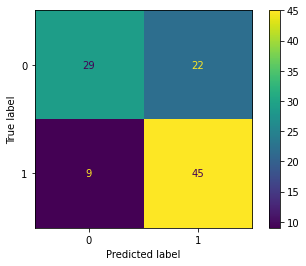

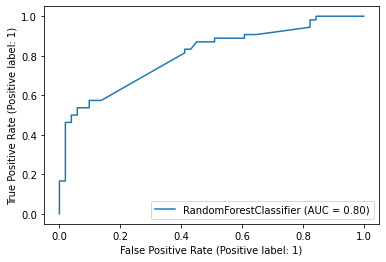

shape of words array = (420, 50)
shape of bigrams array = (420, 50)
<-------------- common words ------------------>
common words, row count: 420 


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,black,new,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.627663,0.631457,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 420 


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,khan accused,accused ignoring,ignoring silvertown,silvertown tunnels,tunnels impact,impact air,air quality,quality ldreporter,khan urges,urges pm,pm change,change isolation,isolation rules,rules early,crime scene
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from WORDS only ---------->
shape of df_all_data = (420, 52)

 <----- First 2 rows of df_all_data ----->


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates,target,Tweet_lemmatized
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '..."
1,0.0,0.627663,0.631457,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l..."


shape of labels = (420,)
shape of features = (420, 50)
Training Features Shape: (315, 50)
Training Labels Shape: (315,)
Testing Features Shape: (105, 50)
Testing Labels Shape: (105,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.7047619047619048
precision 0.6716417910447762
recall 0.8333333333333334
Area under the curve score 0.7009803921568628




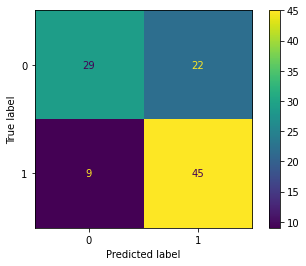

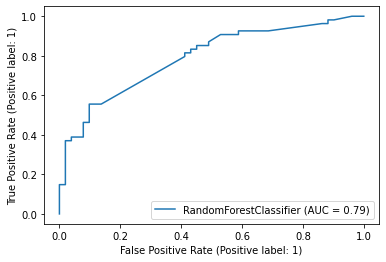

shape of words array = (420, 50)
shape of bigrams array = (420, 50)
<-------------- common words ------------------>
common words, row count: 420 


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,black,new,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.627663,0.631457,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 420 


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,khan accused,accused ignoring,ignoring silvertown,silvertown tunnels,tunnels impact,impact air,air quality,quality ldreporter,khan urges,urges pm,pm change,change isolation,isolation rules,rules early,crime scene
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from BIGRAMS only ---------->
shape of df_all_data = (420, 52)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,ignoring silvertown,silvertown tunnels,tunnels impact,impact air,air quality,quality ldreporter,khan urges,urges pm,pm change,change isolation,isolation rules,rules early,crime scene,target,Tweet_lemmatized
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '..."
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l..."


shape of labels = (420,)
shape of features = (420, 50)
Training Features Shape: (315, 50)
Training Labels Shape: (315,)
Testing Features Shape: (105, 50)
Testing Labels Shape: (105,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6
precision 0.5681818181818182
recall 0.9259259259259259
Area under the curve score 0.5904139433551199




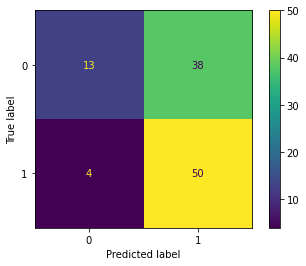

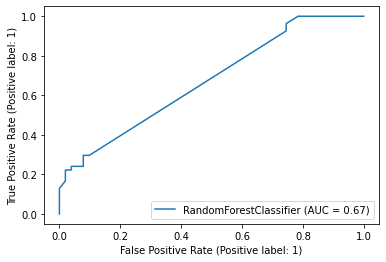

shape of words array = (420, 100)
shape of bigrams array = (420, 100)
<-------------- common words ------------------>
common words, row count: 420 


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,dead,tory,need,search,massive,corner,multiple,londoners,probe,crash,fatal,gangs,times,fighting,court
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.558428,0.561803,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 420 


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,covid sadiq,car crash,driving news,mask tube,offence says,says sadiq,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,escomment years,years ago
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (420, 202)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,dead,tory,need,search,massive,corner,multiple,londoners,probe,crash,fatal,gangs,times,fighting,court
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of labels = (420,)
shape of features = (420, 200)
Training Features Shape: (315, 200)
Training Labels Shape: (315,)
Testing Features Shape: (105, 200)
Testing Labels Shape: (105,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6952380952380952
precision 0.7391304347826086
recall 0.6296296296296297
Area under the curve score 0.6971677559912854




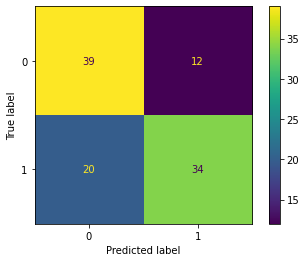

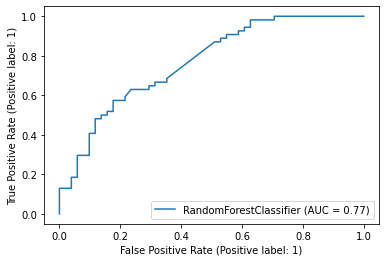

shape of words array = (420, 100)
shape of bigrams array = (420, 100)
<-------------- common words ------------------>
common words, row count: 420 


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,dead,tory,need,search,massive,corner,multiple,londoners,probe,crash,fatal,gangs,times,fighting,court
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.558428,0.561803,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 420 


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,covid sadiq,car crash,driving news,mask tube,offence says,says sadiq,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,escomment years,years ago
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from WORDS only ---------->
shape of df_all_data = (420, 102)

 <----- First 2 rows of df_all_data ----->


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,need,search,massive,corner,multiple,londoners,probe,crash,fatal,gangs,times,fighting,court,target,Tweet_lemmatized
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '..."
1,0.0,0.558428,0.561803,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l..."


shape of labels = (420,)
shape of features = (420, 100)
Training Features Shape: (315, 100)
Training Labels Shape: (315,)
Testing Features Shape: (105, 100)
Testing Labels Shape: (105,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6761904761904762
precision 0.75
recall 0.5555555555555556
Area under the curve score 0.6797385620915033




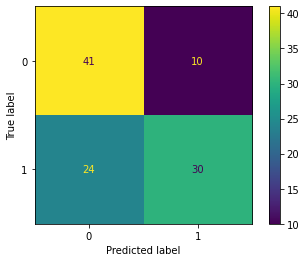

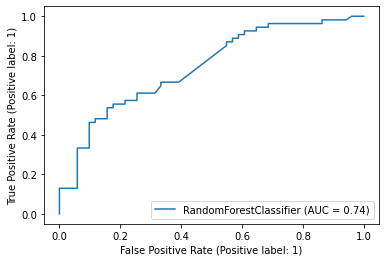

shape of words array = (420, 100)
shape of bigrams array = (420, 100)
<-------------- common words ------------------>
common words, row count: 420 


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,dead,tory,need,search,massive,corner,multiple,londoners,probe,crash,fatal,gangs,times,fighting,court
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.558428,0.561803,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 420 


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,covid sadiq,car crash,driving news,mask tube,offence says,says sadiq,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,escomment years,years ago
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from BIGRAMS only ---------->
shape of df_all_data = (420, 102)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,driving news,mask tube,offence says,says sadiq,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,escomment years,years ago,target,Tweet_lemmatized
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '..."
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l..."


shape of labels = (420,)
shape of features = (420, 100)
Training Features Shape: (315, 100)
Training Labels Shape: (315,)
Testing Features Shape: (105, 100)
Testing Labels Shape: (105,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6
precision 0.5697674418604651
recall 0.9074074074074074
Area under the curve score 0.590958605664488




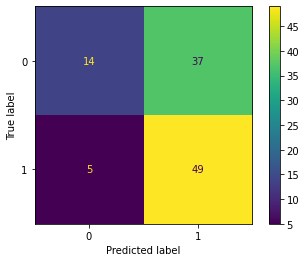

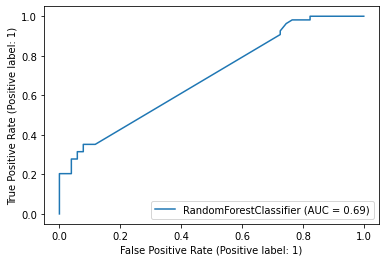

In [27]:
n=50 # number of words, bigrams to include in vocabularies
myMode = features_mode.DEFAULT # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words and Bigrams, Vocab Count: 50'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='Y')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

myMode = features_mode.WORDS # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words only, Vocab Count: 50'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

myMode = features_mode.BIGRAMS # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Bigrams only, Vocab Count: 50'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

n=100 # number of words, bigrams to include in vocabularies
myMode = features_mode.DEFAULT # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words and Bigrams, Vocab Count: 100'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

myMode = features_mode.WORDS # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words only, Vocab Count: 100'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

myMode = features_mode.BIGRAMS # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Bigrams only, Vocab Count: 100'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

In [28]:
rf_results_df.sort_values(by='auc', ascending=False)

,description,accuracy,precision,recall,auc,true positive,false positive,true negative,false negative
0,"Features: Words and Bigrams, Vocab Count: 50",0.704762,0.671642,0.833333,0.700980,45,22,29,9
1,"Features: Words only, Vocab Count: 50",0.704762,0.671642,0.833333,0.700980,45,22,29,9
3,"Features: Words and Bigrams, Vocab Count: 100",0.695238,0.739130,0.629630,0.697168,34,12,39,20
4,"Features: Words only, Vocab Count: 100",0.676190,0.750000,0.555556,0.679739,30,10,41,24
5,"Features: Bigrams only, Vocab Count: 100",0.600000,0.569767,0.907407,0.590959,49,37,14,5
2,"Features: Bigrams only, Vocab Count: 50",0.600000,0.568182,0.925926,0.590414,50,38,13,4


### Comments

Best results when using both words and bigrams and also when using the top 50 (rather than 100) words/bigrams in their respective vocabularies.

I'm actually surprised that we observed results as good as this given we had such a small dataset. However, it should be noted that the results are influenced by the tweets randomly chosen to pad out the 'FOR' class and in other runs we achieved better performance and this was achieved with different configurations for n and words +/- bigrams.
- For comparison, Bovet results were as follows:
    - AUC: 0.89
    - Accuracy: 0.81
    - Precision 0.81
    - Recall: 0.81
- Our results might be being driven by the good recall results - maybe words used are so strong they clearly identify the against camp and such good results for against camp are also boosting overall precision results.

Let's test this by visualising top 20 most important features in our best module permutation.

shape of words array = (420, 50)
shape of bigrams array = (420, 50)
<-------------- common words ------------------>
common words, row count: 420 


,crime,khan,sadiq,stabbing,police,mayor,stabbed,murder,hospital,death,yearold,woman,arrested,life,news,...,black,new,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates
0,0.0,0.000000,0.000000,0.376452,0.402586,0.0,0.0,0.0,0.0,0.0,0.0,0.453084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.627663,0.631457,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 420 


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,khan accused,accused ignoring,ignoring silvertown,silvertown tunnels,tunnels impact,impact air,air quality,quality ldreporter,khan urges,urges pm,pm change,change isolation,isolation rules,rules early,crime scene
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (420, 102)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,black,new,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of labels = (420,)
shape of features = (420, 100)
Training Features Shape: (315, 100)
Training Labels Shape: (315,)
Testing Features Shape: (105, 100)
Testing Labels Shape: (105,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.7047619047619048
precision 0.6716417910447762
recall 0.8333333333333334
Area under the curve score 0.7009803921568628




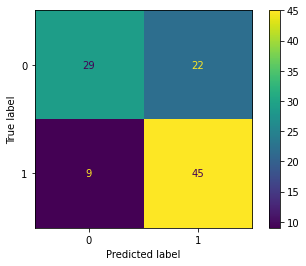

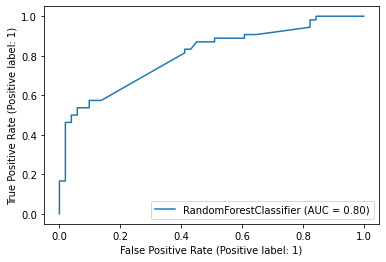

{'description': 'Features: Words and Bigrams, Vocab Count: 100',
 'accuracy': 0.7047619047619048,
 'precision': 0.6716417910447762,
 'recall': 0.8333333333333334,
 'auc': 0.7009803921568628,
 'true positive': 45,
 'false positive': 22,
 'true negative': 29,
 'false negative': 9}

In [29]:
n=50 # number of words, bigrams to include in vocabularies
myMode = features_mode.DEFAULT # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words and Bigrams, Vocab Count: 100'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='Y')

rf_result_row

In [30]:
# Calculate feature importances
importances = rf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
    
feature_list = list(df_all_data.columns)
    
# Rearrange feature names so they match the sorted feature importances
names = [feature_list[i] for i in indices]
    
# select top 20 
n_features = 25
top_names = names[:n_features]
top_n_indices = indices[:n_features]
top_importances = importances[top_n_indices]

feature_importance_df = pd.DataFrame(list(zip(top_names, top_importances)),
               columns =['word_or_bigram', 'importance_value'])



In [31]:
import altair as alt

bar = alt.Chart(feature_importance_df, title='Feature Importance').mark_bar(
    opacity=0.6, color='firebrick', size=20).encode(
    y=alt.Y('word_or_bigram:N', axis=alt.Axis(title=None, ticks=False), sort='-x'),
    x=alt.X('importance_value:Q', axis=None),  
)

text = alt.Chart(feature_importance_df).mark_text(
    align='center',
    baseline='middle',
    color='white',
    dx=-20 
).encode(
    y=alt.Y('word_or_bigram:N', axis=alt.Axis(ticks=False), sort='-x'),
    x=alt.X('importance_value:Q', axis=None),
    text=alt.Text('importance_value:Q', format=',.2')
)

(bar + text).properties(
    width=400,
    height=550).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0)

alt.LayerChart(...)

## Check how many tweets contain each important word and see what label they have
- We load 'twitter_features.csv' as this contains all the features, along with lemmatized tokens and the associated label
- for each of the most important words, find out how many for and against tweets contain those words as a proportion of all for and against tweets

In [32]:
tweets_and_features = pd.read_csv('./DataSources/TwitterData/twitter_features.csv')

print(tweets_and_features.shape)
display(tweets_and_features.head(2))

all_tweets_count = tweets_and_features.target.count()
for_tweets_count = tweets_and_features['target'][tweets_and_features.target==0].count()
against_tweets_count = tweets_and_features['target'][tweets_and_features.target==1].count()

print("total number of tweets: {}, number with label = FOR: {}, number with label = AGAINST: {}".format(all_tweets_count,
                                                                                                       for_tweets_count,
                                                                                                       against_tweets_count))



(420, 102)


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,black,new,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


total number of tweets: 420, number with label = FOR: 210, number with label = AGAINST: 210


In [34]:
def get_stats(tweets_and_features, word, for_tweets_count, against_tweets_count):
    for_count = tweets_and_features[word][(tweets_and_features[word] > 0) & 
                                          (tweets_and_features.target==0)].count()
    
    for_pct = for_count / for_tweets_count
    
    against_count = tweets_and_features[word][(tweets_and_features[word] > 0) & 
                                          (tweets_and_features.target==1)].count()
    
    against_pct = against_count / against_tweets_count
    
    stats_row = {'word': word,
            'for_count': for_count,
            'against_count': against_count,
            'for_pct': for_pct,
            'against_pct': against_pct}
    
    return stats_row

words = ['crime', 'sadiq', 'khan', 'stabbing', 'police', 'news', 'live', 'murder', 'sadiq khan', 'stabbed', 'death']
stats_df = pd.DataFrame(columns=['word', 'for_count', 'against_count', 'for_pct', 'against_pct'])

for word in words:
    stats_row = get_stats(tweets_and_features, word, for_tweets_count, against_tweets_count)
    stats_df = stats_df.append(stats_row, ignore_index=True)
    
stats_df

,word,for_count,against_count,for_pct,against_pct
0,crime,51,15,0.242857,0.071429
1,sadiq,41,12,0.195238,0.057143
2,khan,40,14,0.190476,0.066667
3,stabbing,19,18,0.090476,0.085714
4,police,8,21,0.038095,0.100000
5,news,14,3,0.066667,0.014286
6,live,4,6,0.019048,0.028571
7,murder,10,14,0.047619,0.066667
8,sadiq khan,37,10,0.176190,0.047619
9,stabbed,13,14,0.061905,0.066667


### Comments
lot answer, answer agree - these are a large number of retweets of the same tweet - I questioned whether to remove retweets but I believe they should be retained because they aren't retweeted by the same person and the pure volume of them can influence trending topics in Twitter and so is a measure of interest. However 

## <---- see what Bovet said about retweets ---->

### Now double check the most important features and see whether they exist as text AND hashtags
- if they do exist then our logic is wrong
- Check to see any hashtags in a tweets which has the following words present in the text (many of the important features aren't included in our labelling hashtags):
    - crime
    - answer
    - sadiqkhan
    - stabbing

In [35]:
def check_for_text_and_hashtags(tweets, word):
    print("\n<---------------------------- processing {} ---------------------------->\n".format(word))
    clean_shape = tweets[['hashtags', 'Clean_MessageText', 'Clean_MessageText_refined']][tweets.Clean_MessageText.str.contains(word)].shape
    refined_clean = tweets[['hashtags', 'Clean_MessageText', 'Clean_MessageText_refined']][tweets.Clean_MessageText_refined.str.contains(word)]

    refined_clean_shape = refined_clean.shape
    print("Number of tweets containing {} in Clean_MessageText is {} and in Clean_MessageText_refined is {}".format(word,
                                                                                                                   clean_shape[0],
                                                                                                                   refined_clean_shape[0]))
    
    # now we want tweets that contain the word AND also have the word in their hashtags
    
    tweet_count = 0
    for index, tweet in refined_clean.iterrows():
        my_hashtags = string_to_list_hash(tweet['hashtags'])
        my_hashtags_as_set = set(my_hashtags)
        
        intersection = my_hashtags_as_set.intersection(word)
        
        if len(intersection) > 0:
            print(tweets.hashtags)
        else:
            tweet_count = tweet_count + 1
            
    print("Number of tweets with clean message text which do not contain a hashtag used to label: {}".format(tweet_count))
    
word_list = ['crime', 'answer', 'sadiqkhan', 'stabbing']

print("Shape of original dataframe: {}".format(pruned_tweets.shape))
          
for word in word_list:
    check_for_text_and_hashtags(pruned_tweets, word)


Shape of original dataframe: (420, 7)

<---------------------------- processing crime ---------------------------->

Number of tweets containing crime in Clean_MessageText is 188 and in Clean_MessageText_refined is 80
Number of tweets with clean message text which do not contain a hashtag used to label: 80

<---------------------------- processing answer ---------------------------->

Number of tweets containing answer in Clean_MessageText is 1 and in Clean_MessageText_refined is 1
Number of tweets with clean message text which do not contain a hashtag used to label: 1

<---------------------------- processing sadiqkhan ---------------------------->

Number of tweets containing sadiqkhan in Clean_MessageText is 19 and in Clean_MessageText_refined is 2
Number of tweets with clean message text which do not contain a hashtag used to label: 2

<---------------------------- processing stabbing ---------------------------->

Number of tweets containing stabbing in Clean_MessageText is 77 and

### Comments 
We can see from pruned_tweets.head() that labelling hashtags are removed from Clean_MessageText_refined and we can also see that our double check confirms we don't have any tweets where Clean_MessageText_refined contains a word used in a labelling hashtag AND having that hashtag in its list of hashtags.

We test this seperately in Appendix B and we confirm we are satisfied this logic is working as expected.

### We now go one step further and find optimal hyperparameters
- Note that we reuse the train and test data created in order to identify most important features and so we know this is our optimal configuration.
- We also include the hyperparameters used as defaults previously within the hyperparameter grid values as these provide a reasonable starting point
    - {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
    
#### First recreate features

In [37]:
n=50 # number of words, bigrams to include in vocabularies
myMode = features_mode.DEFAULT # 'DEFAULT WORDS BIGRAMS'

words_vocab, ngrams_vocab = get_words_ngrams(pruned_tweets.Clean_MessageText_refined, n)
df_individual_words = get_word_features(words_vocab, corpus)
df_ngrams = get_bigram_features(ngrams_vocab, corpus)

features, labels, df_all_data = get_features_and_labels(pruned_tweets, df_individual_words, df_ngrams, 
                                           myMode, printFile='N')

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

train_features.shape, test_features.shape

shape of words array = (420, 50)
shape of bigrams array = (420, 50)
<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (420, 102)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,carnage increase,increase reduce,mayor sadiq,stabbed death,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,knife crime,live updates,...,black,new,assault,station,south,daylight,attack,year,week,violence,wearing,park,officers,criminal,updates
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of labels = (420,)
shape of features = (420, 100)


((315, 100), (105, 100))

In [38]:
import time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'oob_score' : [True],
    'max_depth': [5, 10, 20, 30],
    'max_features': [100, 200],
    'min_samples_leaf': [1, 5, 10, 20, 30],
    'min_samples_split': [2, 10, 20, 30],
    'n_estimators': [250, 500, 1000]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
gs_rf = GridSearchCV(estimator = rf, param_grid = param_grid, refit=True,
                          cv = 3, n_jobs = -1, verbose = 2)

tic = time.perf_counter()
gs_rf.fit(train_features, train_labels)
toc = time.perf_counter()

print(f"Running the Random Forest classifer on our best features dataset took {toc - tic:0.4f} seconds")

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


C:\Users\phil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning:

One or more of the test scores are non-finite: [0.67936508 0.68571429 0.68253968 0.68253968 0.68888889 0.68253968
 0.68253968 0.68571429 0.67936508 0.66984127 0.67936508 0.67619048
 0.66349206 0.66031746 0.65396825 0.66031746 0.65079365 0.65714286
 0.65396825 0.65714286 0.66031746 0.65714286 0.65714286 0.65714286
 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286
 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286
 0.61269841 0.61269841 0.61269841 0.61269841 0.61269841 0.61269841
 0.61269841 0.61269841 0.61269841 0.61269841 0.61269841 0.61269841
 0.5047619  0.5047619  0.5047619  0.5047619  0.5047619  0.5047619
 0.5047619  0.5047619  0.5047619  0.5047619  0.5047619  0.5047619
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 20, 30],
                         'max_features': [100, 200],
                         'min_samples_leaf': [1, 5, 10, 20, 30],
                         'min_samples_split': [2, 10, 20, 30],
                         'n_estimators': [250, 500, 1000],
                         'oob_score': [True]},
             verbose=2)

Running the Random Forest classifer on our best features dataset took 165.9089 seconds


------------------------------------------------------------------
Printing performance metrics for optimal model
------------------------------------------------------------------

prediction accuracy 0.6666666666666666
precision 0.6338028169014085
recall 0.8333333333333334
Area under the curve score 0.661764705882353




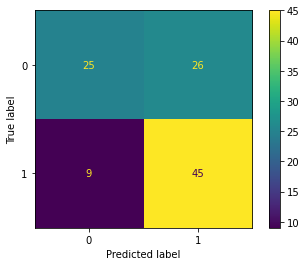

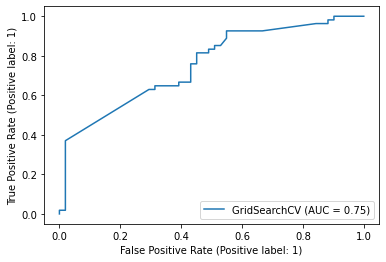

In [39]:
y_pred = gs_rf.predict(test_features)

accuracy, precision, recall, roc_auc, tn, fp, fn, tp = ml_performance.RF_performance_reporting(gs_rf, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                y_pred, 
                                                                                'optimal model', 
                                                                                print_output=True)

In [40]:
print(gs_rf.best_score_, gs_rf.best_params_)

0.6888888888888888 {'bootstrap': True, 'max_depth': 5, 'max_features': 100, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500, 'oob_score': True}


### Comments
The cross validated results ever so slightly worse than our original results but they were cross validated and so we would have more confidence that this model is more generalisable and so is the preferred model.

In [41]:
all_unique_users = all_tweets.tweeter_screen_name.nunique()
pruned_unique_users = pruned_tweets.tweeter_screen_name.nunique()

print("Percentage of all tweeters in our pruned dataset = {:.2%}".format(pruned_unique_users / all_unique_users))

Percentage of all tweeters in our pruned dataset = 3.57%


## We now want to predict classes for remaining tweets
First Create features for whole dataset
- We use vocabs from the pruned dataset but the corpus is based on the bigger dataset 
- the bigger dataset will comprise tweets which have a label = 'NONE' and so we won't be predicting using any data used previously to train our model
- we will then join the results of these predicted labels with tweets from the original dataset that had labels = 'FOR' or 'AGAINST'
    - this does mean we lose tweets which had hashtags that weren't used to label our tweets but this a small number of tweets and so doesn't have a material effect

In [42]:
all_tweets_original['label'] = '' 
all_tweets_original['label'] = all_tweets_original['hashtags'].apply(lambda x: get_tweet_class(x, set_for, set_against))

print("shape for original tweets: {}".format(all_tweets_original.shape))

all_tweets_new = all_tweets_original[~all_tweets_original['Clean_MessageText'].isnull()]
all_tweets_new = all_tweets_new[all_tweets_new['Clean_MessageText'].str.len() > 4]
print("shape for original tweets where bad message text removed: {}".format(all_tweets_new.shape))

remaining_tweets = all_tweets_new[all_tweets_new.label=='NONE'].copy().reset_index(drop=True)

remaining_tweets['Clean_MessageText_refined'] = remaining_tweets.apply(lambda x: remove_label_hashtags(x['Clean_MessageText'], 
                                                                                                x['hashtags'], ignore_words), 
                                                                                                 axis=1)

print("labels in remaining tweets {}".format(remaining_tweets.label.unique()))
print("shape for remaining tweets where containing purely tweets without hashtags: {}".format(remaining_tweets.shape))

remaining_tweets.head()

shape for original tweets: (41706, 27)
shape for original tweets where bad message text removed: (41472, 27)
labels in remaining tweets ['NONE']
shape for remaining tweets where containing purely tweets without hashtags: (39353, 28)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,is_retweet,extract_run_date,retrieved_using_search_term,retweeted,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins,label,Clean_MessageText_refined
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,Y,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,2021-07-28 00:00:00,NONE,good boris johnson issues scathing response sa...
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,Y,20210728,London AND knife AND crime,['@NaheedMajeed'],['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,2021-07-28 00:00:00,NONE,spot track break record teenage murdersstop se...
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,Y,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,2021-07-28 00:00:00,NONE,boris today speaking nick ferrari khan … done ...
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,Y,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,2021-07-28 00:00:00,NONE,good boris johnson issues scathing response sa...
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,Y,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,2021-07-28 00:00:00,NONE,boris today speaking nick ferrari khan … done ...


### Create features
We use the new tweets to create our corpus but reuse words_vocab, ngrams_vocab created from the pruned tweets so that our feature categories are the same as used to train our model. 
- words_vocab, ngrams_vocab were created previously as input to our grid search

In [43]:
n=50

corpus_remaining = get_corpus(remaining_tweets)

df_individual_words = get_word_features(words_vocab, corpus_remaining)
df_ngrams = get_bigram_features(ngrams_vocab, corpus_remaining)

df_all_data = df_ngrams.join(df_individual_words)
features = np.array(df_all_data)

print("shape of features array: {}".format(features.shape))

The document corpus has length: 39353
<----------------- corpus -------------->


['good boris johnson issues scathing response sadiq khans record knife crime',
 'spot track break record teenage murdersstop search vital tool no…',
 'boris today speaking nick ferrari khan … done fight knife crime streets of…',
 'good boris johnson issues scathing response sadiq khans record knife crime',
 'boris today speaking nick ferrari khan … done fight knife crime streets of…']

['recognise officers want identify connection stabbing west india quay dlr station tu…',
 'breaking police rush scene horror stabbing knifed times broad daylight yet another st…',
 'breaking police rush scene horror stabbing knifed times broad daylight yet another st…',
 'recognise officers want identify connection stabbing west india quay dlr station tu…',
 'recognise officers want identify connection stabbing west india quay dlr station tu…']


<--------- original tweets ------------->
The tweet dataframe has length: 39353


0    good boris johnson issues scathing response sa...
1    spot track break record teenage murdersstop se...
2    boris today speaking nick ferrari khan … done ...
3    good boris johnson issues scathing response sa...
4    boris today speaking nick ferrari khan … done ...
Name: Clean_MessageText_refined, dtype: object

39348    recognise officers want identify connection st...
39349    breaking police rush scene horror stabbing kni...
39350    breaking police rush scene horror stabbing kni...
39351    recognise officers want identify connection st...
39352    recognise officers want identify connection st...
Name: Clean_MessageText_refined, dtype: object

shape of words array = (39353, 50)
shape of bigrams array = (39353, 50)
shape of features array: (39353, 100)


In [44]:
predictions = gs_rf.predict(features)

In [45]:
df_predictions = pd.DataFrame(predictions, columns = ['predicted_label'])
print("shape of predictions array: {}".format(df_predictions.shape))
print("number of predictions = FOR: {:,}".format(df_predictions['predicted_label'][df_predictions.predicted_label==0].count()))
print("shape of predictions = AGAINST: {:,}".format(df_predictions['predicted_label'][df_predictions.predicted_label==1].count()))

display(df_predictions.head(2))
display(df_predictions.tail(2))

shape of predictions array: (39353, 1)
number of predictions = FOR: 18,937
shape of predictions = AGAINST: 20,416


,predicted_label
0,0
1,1


,predicted_label
39351,1
39352,1


### Comments
While we have labeled a number of tweets as being 'FOR' the mayor, the reality is that we had too few tweets to be able to realistically predict whether a tweet is actually for the mayor and instead what we are really predicting is that the tweet isn't vocally against the mayor. So what we therefore have is a body of tweets where we've identified about 25% being against the mayor and these can be fairly accurately identified by the language they use within their tweets. 

However, as we saw previously, we know that less than 50 tweets used hashtags that were explicitly pro Mayor versus around 900 using anti mayor hashtags.

### Combine datasets and export
We now merge our predictions with the remaining tweet data and then convert the labels to FOR if predicted label was 0 and AGAINST if it was 1.
- We know from previously that the indexes of both tweets and predictions are the same and so we can just join the data

Then we concatenate our data with the pruned dataset to produce a single dataset of labeled tweets.

In [46]:
remaining_tweets_labeled = remaining_tweets.join(df_predictions)

remaining_tweets_labeled.loc[remaining_tweets_labeled.predicted_label == 0,'label'] = 'NOT_AGAINST'
remaining_tweets_labeled.loc[remaining_tweets_labeled.predicted_label == 1,'label'] = 'AGAINST'

remaining_tweets_labeled.drop('predicted_label', axis = 1, inplace=True)

display(remaining_tweets_labeled.head())
display(remaining_tweets_labeled.tail())

,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,is_retweet,extract_run_date,retrieved_using_search_term,retweeted,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins,label,Clean_MessageText_refined
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,Y,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,2021-07-28 00:00:00,NOT_AGAINST,good boris johnson issues scathing response sa...
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,Y,20210728,London AND knife AND crime,['@NaheedMajeed'],['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,2021-07-28 00:00:00,AGAINST,spot track break record teenage murdersstop se...
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,Y,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,2021-07-28 00:00:00,NOT_AGAINST,boris today speaking nick ferrari khan … done ...
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,Y,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,2021-07-28 00:00:00,NOT_AGAINST,good boris johnson issues scathing response sa...
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,Y,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,2021-07-28 00:00:00,NOT_AGAINST,boris today speaking nick ferrari khan … done ...


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,is_retweet,extract_run_date,retrieved_using_search_term,retweeted,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins,label,Clean_MessageText_refined
39348,41700,1428334719226322946,2021-08-19 12:35:08,1086949238574075904,FrankieS,FrankieSMCW,unknown,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,0,198,Y,20210826,London AND stabbing,['@BTPLondon'],[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-19 12:35:08,2021-08-19 12:00:00,2021-08-19 00:00:00,AGAINST,recognise officers want identify connection st...
39349,41701,1428283084219330566,2021-08-19 09:09:58,872173973785673728,jim._.price75,jimprice75,"Sheffield, England",RT @suemitch2017: BREAKING: Police rush to sce...,NaN,NaN,0,14,Y,20210826,London AND stabbing,['@suemitch2017'],[],[],BREAKING Police rush to scene of horror Londo...,"['breaking', 'police', 'rush', 'to', 'scene', ...","['breaking', 'police', 'rush', 'scene', 'horro...","['breaking', 'police', 'rush', 'scene', 'horro...",breaking police rush scene horror stabbing kni...,2021-08-19 09:09:58,2021-08-19 00:00:00,2021-08-19 00:00:00,NOT_AGAINST,breaking police rush scene horror stabbing kni...
39350,41702,1428234744450387968,2021-08-19 05:57:53,985978695860019200,Dianne mary,Diannebrown128,unknown,RT @suemitch2017: BREAKING: Police rush to sce...,NaN,NaN,0,14,Y,20210826,London AND stabbing,['@suemitch2017'],[],[],BREAKING Police rush to scene of horror Londo...,"['breaking', 'police', 'rush', 'to', 'scene', ...","['breaking', 'police', 'rush', 'scene', 'horro...","['breaking', 'police', 'rush', 'scene', 'horro...",breaking police rush scene horror stabbing kni...,2021-08-19 05:57:53,2021-08-19 00:00:00,2021-08-19 00:00:00,NOT_AGAINST,breaking police rush scene horror stabbing kni...
39351,41703,1428127105179688962,2021-08-18 22:50:09,1226457400812736512,"AnnMorton,",AnnMort92883429,unknown,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,0,198,Y,20210826,London AND stabbing,['@BTPLondon'],[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-18 22:50:09,2021-08-18 12:00:00,2021-08-18 00:00:00,AGAINST,recognise officers want identify connection st...
39352,41705,1428007860609421327,2021-08-18 14:56:19,2728878058,Maria,MariaEW100,Worcester,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,0,198,Y,20210826,London AND stabbing,['@BTPLondon'],[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-18 14:56:19,2021-08-18 12:00:00,2021-08-18 00:00:00,AGAINST,recognise officers want identify connection st...


In [47]:
for_against_tweets = all_tweets_new[all_tweets_new.label.isin(['AGAINST', 'FOR'])].copy().reset_index(drop=True)

frames = [for_against_tweets, remaining_tweets_labeled]

all_labeled_tweets = pd.concat(frames).reset_index(drop=True)

print("shape of all_labeled_tweets: {}".format(all_labeled_tweets.shape))
display(all_labeled_tweets.head(3))
display(all_labeled_tweets.tail(3))

shape of all_labeled_tweets: (39857, 28)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,is_retweet,extract_run_date,retrieved_using_search_term,retweeted,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins,label,Clean_MessageText_refined
0,728,1419696027821481990,2021-07-26 16:28:04,3081529131,Flying Eze,flyingeze,unknown,"Man seriously injured in stabbing, teen girl a...",NaN,NaN,0,0,N,20210728,London AND knife AND crime,[],[],"['#crime', '#hortonandwellington', '#knife']",Man seriously injured in stabbing teen girl an...,"['man', 'seriously', 'injured', 'in', 'stabbin...","['seriously', 'injured', 'stabbing', 'teen', '...","['seriously', 'injured', 'stabbing', 'teen', '...",seriously injured stabbing teen girl woman cha...,2021-07-26 16:28:04,2021-07-26 12:00:00,2021-07-26 00:00:00,AGAINST,NaN
1,980,1419551117877338112,2021-07-26 06:52:15,1357615215416860672,NEWS-ONE,NEWSONE14898745,unknown,'You’ve had six years!’ #Sadiq #Khan lambasted...,NaN,NaN,0,0,N,20210728,London AND knife AND crime,[],[],"['#sadiq', '#khan', '#knife', '#crime']",You’ve had six years’ Sadiq Khan lambasted ove...,"['you', '’', 've', 'had', 'six', 'years', '’',...","['’', 'six', 'years', '’', 'sadiq', 'khan', 'l...","['’', 'six', 'years', '’', 'sadiq', 'khan', 'l...",’ six years ’ sadiq khan lambasted knife crime...,2021-07-26 06:52:15,2021-07-26 00:00:00,2021-07-26 00:00:00,AGAINST,NaN
2,1164,1418648214689955841,2021-07-23 19:04:26,3935792619,Marie Bell,Mariebe10098426,Cumbria.,RT @BermudaBat: 'You’ve had six years!’ @Sadiq...,NaN,NaN,0,1,Y,20210728,London AND knife AND crime,['@BermudaBat'],['@SadiqKhan'],['#khanage'],You’ve had six years’ lambasted over knife c...,"['you', '’', 've', 'had', 'six', 'years', '’',...","['’', 'six', 'years', '’', 'lambasted', 'knife...","['’', 'six', 'years', '’', 'lambasted', 'knife...",’ six years ’ lambasted knife crime surge khan...,2021-07-23 19:04:26,2021-07-23 12:00:00,2021-07-23 00:00:00,AGAINST,NaN


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,is_retweet,extract_run_date,retrieved_using_search_term,retweeted,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins,label,Clean_MessageText_refined
39854,41702,1428234744450387968,2021-08-19 05:57:53,985978695860019200,Dianne mary,Diannebrown128,unknown,RT @suemitch2017: BREAKING: Police rush to sce...,NaN,NaN,0,14,Y,20210826,London AND stabbing,['@suemitch2017'],[],[],BREAKING Police rush to scene of horror Londo...,"['breaking', 'police', 'rush', 'to', 'scene', ...","['breaking', 'police', 'rush', 'scene', 'horro...","['breaking', 'police', 'rush', 'scene', 'horro...",breaking police rush scene horror stabbing kni...,2021-08-19 05:57:53,2021-08-19 00:00:00,2021-08-19 00:00:00,NOT_AGAINST,breaking police rush scene horror stabbing kni...
39855,41703,1428127105179688962,2021-08-18 22:50:09,1226457400812736512,"AnnMorton,",AnnMort92883429,unknown,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,0,198,Y,20210826,London AND stabbing,['@BTPLondon'],[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-18 22:50:09,2021-08-18 12:00:00,2021-08-18 00:00:00,AGAINST,recognise officers want identify connection st...
39856,41705,1428007860609421327,2021-08-18 14:56:19,2728878058,Maria,MariaEW100,Worcester,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,0,198,Y,20210826,London AND stabbing,['@BTPLondon'],[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-18 14:56:19,2021-08-18 12:00:00,2021-08-18 00:00:00,AGAINST,recognise officers want identify connection st...


### Sense check our data
- Look at shapes before and after
- Look at label counts of for, against, not_against

In [48]:
print("Number of rows in for_against dataframe: {}, remaining_tweets_labeled: {}, and combined: {}".format(for_against_tweets['label'].count(), 
                                                                                                           remaining_tweets_labeled['label'].count(), 
                                                                                                           all_labeled_tweets['label'].count()))

all_labeled_tweets_count = all_labeled_tweets['label'].count()
for_count_labeled = all_labeled_tweets['label'][all_labeled_tweets.label == 'FOR'].count()
for_pct_labeled = for_count_labeled / all_labeled_tweets_count
against_count_labeled = all_labeled_tweets['label'][all_labeled_tweets.label == 'AGAINST'].count()
against_pct_labeled = against_count_labeled / all_labeled_tweets_count
not_against_count_labeled = all_labeled_tweets['label'][all_labeled_tweets.label == 'NOT_AGAINST'].count()
not_against_pct_labeled = not_against_count_labeled / all_labeled_tweets_count

print("\nCount (and percent) of labels by category in combined dataframe all_labeled_tweets:")
print("'FOR': {:,}({:.2%}), \n'AGAINST': {:,}({:.2%}), \n'NOT AGAINST': {:,}({:.2%})".format(for_count_labeled, 
                                                                                 for_pct_labeled,
                                                                                 against_count_labeled, 
                                                                                 against_pct_labeled,
                                                                                 not_against_count_labeled,
                                                                                 not_against_pct_labeled))



Number of rows in for_against dataframe: 504, remaining_tweets_labeled: 39353, and combined: 39857

Count (and percent) of labels by category in combined dataframe all_labeled_tweets:
'FOR': 26(0.07%), 
'AGAINST': 20,894(52.42%), 
'NOT AGAINST': 18,937(47.51%)


### Sense Check - Comments

The combined dataset has the expected number of rows: all tweets minus tweets with hashtags not equal to FOR or AGAINST
The 'FOR' tweets are same as in original dataset
The 'AGAINST' tweets = tweets labelled AGAINST in original dataset plus tweets predicted as against
'NOT AGAINST' tweets comprise the balance

We therefore conclude the data has been correctly constructed

### Reasonableness check - compare with hand labeling
We use hashtag cooccurrance as the basis for labelling our tweets prior to performing machine learning. Another common approach is to manually label them and this approach has been seen to produce better results than lexicon based sentiment analysis [1] but its main drawback is time taken to manually label the tweets. However, reviewing a subset of tweets we have specified as being AGAINST or NOT_AGAINST to see how we would have labeled them manually is a good sense check of the classification model's ability to produce reasonable predictions. This is what we will do now.
- We will randomly sample 100 tweets from remaining_tweets and export them to a csv file where we will manually annotate labels to them. We suffix the annotated file with '_annotated'
- We will then import the annotated file, join it to our labeled tweet file and review differences in labeling

Note: editing the file in excel reformats the id field and so we prefix it with a single quote to trick excel into treating the field like a string

#### <--- A different random sample is produced each time and so don't run this next cell unless you want a new sample and want to manually label the new rows --->

In [49]:
random_sample = remaining_tweets[['tweet_id', 'message_text']].sample(n=100).copy()
random_sample['tweet_id'] = random_sample['tweet_id'].astype(str)
random_sample['tweet_id'] = "'" + random_sample['tweet_id']

random_sample.to_csv('./DataSources/TwitterData/sampled_tweets.csv', index=False)

In [50]:
random_sample_annotated = pd.read_csv('./DataSources/TwitterData/sampled_tweets_annotated.csv')
random_sample_annotated['tweet_id'] = random_sample_annotated['tweet_id'].str[1:]
random_sample_annotated['tweet_id'] = random_sample_annotated['tweet_id'].astype(np.int64)

random_sample_annotated.head()

,tweet_id,message_text,annotated_label
0,1418111071995547650,"RT @MarcherLord1: Schoolboy, aged 7, took knif...",AGAINST
1,1428267044928118786,"RT @HonestCitizen62: Sadiq Khan, permanently d...",NOT_AGAINST
2,1426120167952617474,@DanielBayley80 They don’t work for us none of...,AGAINST
3,1427203255105425411,RT @BrexitBassist: Sadiq Khan waffling on as i...,AGAINST
4,1428309594279927811,RT @ripx4nutmeg: The chair of London's Violenc...,NOT_AGAINST


### Now join with remaining_tweets_labeled

In [51]:
remaining_tweets_compare = remaining_tweets_labeled[['tweet_id', 'message_text', 'Clean_MessageText', 'label']].copy()

df_merged = pd.merge(random_sample_annotated, remaining_tweets_compare, left_on='tweet_id', right_on='tweet_id')

df_merged.head()

,tweet_id,message_text_x,annotated_label,message_text_y,Clean_MessageText,label
0,1418111071995547650,"RT @MarcherLord1: Schoolboy, aged 7, took knif...",AGAINST,"RT @MarcherLord1: Schoolboy, aged 7, took knif...",schoolboy aged took knife class “ wanted stab ...,AGAINST
1,1428267044928118786,"RT @HonestCitizen62: Sadiq Khan, permanently d...",NOT_AGAINST,"RT @HonestCitizen62: Sadiq Khan, permanently d...",sadiq khan permanently deeply saddened old sto...,NOT_AGAINST
2,1426120167952617474,@DanielBayley80 They don’t work for us none of...,AGAINST,@DanielBayley80 They don’t work for us none of...,’ work us none council councillors labour sal…,AGAINST
3,1427203255105425411,RT @BrexitBassist: Sadiq Khan waffling on as i...,AGAINST,RT @BrexitBassist: Sadiq Khan waffling on as i...,sadiq khan waffling pm someone important world...,NOT_AGAINST
4,1419726320074952707,RT @KoolKat1025: A woman getting stabbed in Lo...,AGAINST,RT @KoolKat1025: A woman getting stabbed in Lo...,woman getting stabbed yesterday headline news ...,NOT_AGAINST


In [52]:
from sklearn.metrics import confusion_matrix

total_count = df_merged['message_text_x'].count()
against_count_label = df_merged['message_text_x'][df_merged.label == 'AGAINST'].count()
against_count_annot_label = df_merged['message_text_x'][df_merged.annotated_label == 'AGAINST'].count()

print("Total number of records: {}\nAnnotated - AGAINST total: {}\nPredicted - AGAINST total: {}".format(total_count,
      against_count_annot_label,
      against_count_label))

df_merged['predicted_label'] = 0
df_merged['true_label'] = 0

df_merged.loc[df_merged.annotated_label=='AGAINST', 'true_label'] = 1
df_merged.loc[df_merged.label=='AGAINST', 'predicted_label'] = 1

cm = confusion_matrix(df_merged['true_label'], df_merged['predicted_label'])
tn, fp, fn, tp = confusion_matrix(df_merged['true_label'], df_merged['predicted_label']).ravel()

print("\n Confusion matrix results\n")
print("True Negatives {}\nFalse Positives {}\nFalse Negatives {}\nTruePositives {}".format(tn, fp, fn, tp))
cm


Total number of records: 97
Annotated - AGAINST total: 25
Predicted - AGAINST total: 43

 Confusion matrix results

True Negatives 34
False Positives 38
False Negatives 20
TruePositives 5


array([[34, 38],
       [20,  5]], dtype=int64)

### Comments
I treat the manually annotated labels as 'True' labels and the classifier predictions as predicted labels. Producing a confusion matrix shows that we only match 4 out of 21 positive labels (='AGAINST). If we assume that the manual annotation is the more accurate, we can now view each row to understand why it might not have been annotated correctly

In [53]:
df_delta_false_negatives = df_merged[['annotated_label', 'label', 'message_text_x', 'Clean_MessageText']][(df_merged.annotated_label != df_merged.label) 
                                                       & (df_merged.annotated_label == 'AGAINST')]

for index, message in df_delta_false_negatives.iterrows():
    print("label: {}, annotated_label: {}".format(message['label'], message['annotated_label']))
    print(message['message_text_x'] + "\n")
    print(message['Clean_MessageText'] + "\n")

label: NOT_AGAINST, annotated_label: AGAINST
RT @BrexitBassist: Sadiq Khan waffling on as if he is a PM or someone important on the world stage.
He forgets he's just the useless Mayor…

sadiq khan waffling pm someone important world stage forgets hes useless mayor…

label: NOT_AGAINST, annotated_label: AGAINST
RT @KoolKat1025: A woman getting stabbed in London yesterday should be headline news across all media,but it's eerily silent.Was it the " w…

woman getting stabbed yesterday headline news across mediabut eerily silentwas w…

label: NOT_AGAINST, annotated_label: AGAINST
RT @KoolKat1025: A woman getting stabbed in London yesterday should be headline news across all media,but it's eerily silent.Was it the " w…

woman getting stabbed yesterday headline news across mediabut eerily silentwas w…

label: NOT_AGAINST, annotated_label: AGAINST
RT @IanHart14: What a terrible record the London Mayor has on crime. https://t.co/fhkwcxz0UJ

terrible record mayor crime

label: NOT_AGAINST, annot

### I need to remark on these results, which aren't brilliant tbh - 

## Label tweeters based on their tweets
This dataset contains tweets labeled as pro, against or not_against and the final step is to label tweeters as belonging to one of these categories depending on how the majority of their tweets were categorised
- If the count of tweets is equal then the precedence is NOT_AGAINST, then FOR, then AGAINST
    - The logic is that NOT_AGAINST suggests indeterminate tweeter opinion while FOR is more unusual than AGAINST and so if it has equal count then it 'seems' like a more conscious choice by the tweeter

In [54]:
labeled_group = all_labeled_tweets.groupby(['tweeter_screen_name', 'label']).count().reset_index()
pivoted_group = pd.pivot_table(labeled_group, values = 'tweet_id', index=['tweeter_screen_name'], columns = 'label').reset_index()
pivoted_group['AGAINST'] = pivoted_group['AGAINST'].fillna(0)
pivoted_group['FOR'] = pivoted_group['FOR'].fillna(0)
pivoted_group['NOT_AGAINST'] = pivoted_group['NOT_AGAINST'].fillna(0)
pivoted_group['tweeter_label'] = ''

pivoted_group.head()

label,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,0007_vishi,0.0,0.0,1.0,
1,005e5n,0.0,0.0,1.0,
2,007AJSmith,1.0,0.0,1.0,
3,007dmax,1.0,0.0,0.0,
4,007taff,1.0,0.0,0.0,


In [55]:
def label_tweeter(for_count, against_count, not_against_count):
    
    tweeter_label = 'NOT_AGAINST'
    
    if against_count > for_count:
        if against_count > not_against_count:
            tweeter_label = 'AGAINST'
            
    elif for_count > not_against_count:
            tweeter_label = 'FOR'

    return tweeter_label

pivoted_group['tweeter_label'] = pivoted_group.apply(lambda x: label_tweeter(x['FOR'], 
                                                                             x['AGAINST'],
                                                                             x['NOT_AGAINST']), axis=1)

pivoted_group.head()

label,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,0007_vishi,0.0,0.0,1.0,NOT_AGAINST
1,005e5n,0.0,0.0,1.0,NOT_AGAINST
2,007AJSmith,1.0,0.0,1.0,NOT_AGAINST
3,007dmax,1.0,0.0,0.0,AGAINST
4,007taff,1.0,0.0,0.0,AGAINST


In [56]:
all_unique_users_ = pivoted_group['tweeter_screen_name'].nunique()
all_unique_users_against = pivoted_group['tweeter_screen_name'][pivoted_group.tweeter_label=='AGAINST'].nunique()
all_unique_users_for = pivoted_group['tweeter_screen_name'][pivoted_group.tweeter_label=='FOR'].nunique()
all_unique_users_not_against = pivoted_group['tweeter_screen_name'][pivoted_group.tweeter_label=='NOT_AGAINST'].nunique()

print("Unique user counts by opinion:\nAll : {:,}\nAgainst : {:,}\nFor: {}\nNot Against: {:,}".format(all_unique_users_,
                                                                           all_unique_users_against, 
                                                                           all_unique_users_for, 
                                                                           all_unique_users_not_against)) 

all_labeled_tweets.to_csv('./DataSources/TwitterData/labeled_tweets.csv', index=False)
pivoted_group.to_csv('./DataSources/TwitterData/labeled_users.csv', index=False)

Unique user counts by opinion:
All : 22,964
Against : 11,078
For: 16
Not Against: 11,870


# Appendices

## Appendix A - Test the function that assigns class (get_tweet_class)

In [57]:
test_hashtags = ['[]', '[]', '[#a, #b, #c, #d]', '[#a, #b]', '[#x, #y, #z]', '[#a, #x]', '[#a, #b, #x]', '[#a, #x, #y]']
test_hashtags_df = pd.DataFrame(test_hashtags, columns =['hashtags'])

test_for_hashtags = ['#a', '#b', '#c']
test_against_hashtags = ['#x', '#y']

test_set_for = set(test_for_hashtags)
test_set_against = set(test_against_hashtags)

test_hashtags_df['label'] = '' 
test_hashtags_df['label'] = test_hashtags_df['hashtags'].apply(lambda x: get_tweet_class(x, test_set_for, test_set_against))

test_hashtags_df

,hashtags,label
0,[],NONE
1,[],NONE
2,"[#a, #b, #c, #d]",FOR
3,"[#a, #b]",FOR
4,"[#x, #y, #z]",AGAINST
5,"[#a, #x]",FOR
6,"[#a, #b, #x]",FOR
7,"[#a, #x, #y]",AGAINST


### Comments
The results are as expected so happy with the function

# Appendix B - Test stripping of hashtags
The requirement is to strip words from the message text if that word is one of the hashtags used to label our tweets AND the same hashtag is in the list of hashtags previously identified for the tweet.

Hashtags used to label tweets included: 
- #austerity
- #crime
- #policecuts

Use cases to test:
- 1. tweet contains no words in our hashtag list and so text passed through unchanged
- 2. tweet contains a word that's in our hashtag list but the word is not in its list of hashtags and so don't remove it from the message text
- 3. tweet contains a word that's in our hashtag list AND the word is its list of hashtags and so remove it from the message text

Assumes: 
- set_for and set_against have already been populated
- string_to_list(my_str) has been created
- remove_label_hashtags(text, hashtags, ignore_words) has been created

First create a dummy dataframe with test data.

In [58]:
# dictionary with list object in values
details = {
        'Clean_MessageText' : ['actnow climateaction', 
                           'actnow climateaction policecuts', 
                           'actnow climateaction policecuts'],
    'hashtags' : ["['#actnow', '#climateaction']", 
                  "['#actnow', '#climateaction']", 
                  "['#actnow', '#climateaction', '#policecuts']"]
}
  
# creating a Dataframe object 
dummy_df = pd.DataFrame(details)
  
dummy_df

,Clean_MessageText,hashtags
0,actnow climateaction,"['#actnow', '#climateaction']"
1,actnow climateaction policecuts,"['#actnow', '#climateaction']"
2,actnow climateaction policecuts,"['#actnow', '#climateaction', '#policecuts']"


In [59]:
set_for_ = {'#policecuts', '#austerity'}
set_against_ = {'#crime', '#khanage'}

ignore_hashtags_set_ = set_for_.union(set_against_) # create a single set containing all hashtags

ignore_hashtags_ = list(ignore_hashtags_set_) # turn set into a list
ignore_words_ = [w[1:] for w in ignore_hashtags_] # create a list of ignore words which are hashtags but without the '#' 

print("Number of items in set_for: {}, number in set_against: {} and in the combined list: {}".format(len(set_for_),
                                                                                                    len(set_against_),
                                                                                                    len(ignore_words_)))

ignore_words_

Number of items in set_for: 2, number in set_against: 2 and in the combined list: 4


['crime', 'austerity', 'policecuts', 'khanage']

In [60]:
dummy_df['Clean_MessageText_refined'] = dummy_df.apply(lambda x: remove_label_hashtags(x['Clean_MessageText'], 
                                                                                                x['hashtags'], ignore_words_), 
                                                                                                 axis=1)

dummy_df

,Clean_MessageText,hashtags,Clean_MessageText_refined
0,actnow climateaction,"['#actnow', '#climateaction']",actnow climateaction
1,actnow climateaction policecuts,"['#actnow', '#climateaction']",actnow climateaction policecuts
2,actnow climateaction policecuts,"['#actnow', '#climateaction', '#policecuts']",actnow climateaction


## Appendix C - Test labeling of Tweeters works OK
- Load test data from a .csv file because it was an easier to create it

In [61]:
dummy_label_df = pd.read_csv("./DataSources/TwitterData/user_label_testdata.csv")
dummy_label_df.sort_values(by='tweeter_screen_name')

,tweet_id,tweeter_screen_name,label,expected_outcome
35,36,BETTY,NOT_AGAINST,NOT_AGAINST
33,34,BETTY,AGAINST,NOT_AGAINST
32,33,BETTY,AGAINST,NOT_AGAINST
34,35,BETTY,NOT_AGAINST,NOT_AGAINST
31,32,BETTY,FOR,NOT_AGAINST
30,31,BETTY,FOR,NOT_AGAINST
16,17,BRIAN,NOT_AGAINST,NOT_AGAINST
15,16,BRIAN,FOR,NOT_AGAINST
14,15,BRIAN,AGAINST,NOT_AGAINST
3,4,DICK,AGAINST,FOR


In [62]:
dummy_group = dummy_label_df.groupby(['tweeter_screen_name', 'label']).count().reset_index()
sorted_dummy = dummy_group.sort_values(['tweeter_screen_name', 'tweet_id'], ascending=False)

sorted_dummy

,tweeter_screen_name,label,tweet_id,expected_outcome
21,TOM,AGAINST,2,2
22,TOM,FOR,1,1
19,PHIL,FOR,2,2
20,PHIL,NOT_AGAINST,1,1
18,JOHN,FOR,2,2
17,JOHN,AGAINST,1,1
16,JANE,NOT_AGAINST,2,2
15,JANE,FOR,1,1
14,HENRY,NOT_AGAINST,2,2
13,HENRY,AGAINST,1,1


In [63]:
pivoted_dummy = pd.pivot_table(sorted_dummy, values = 'tweet_id', index=['tweeter_screen_name'], columns = 'label').reset_index()
pivoted_dummy['AGAINST'] = pivoted_dummy['AGAINST'].fillna(0)
pivoted_dummy['FOR'] = pivoted_dummy['FOR'].fillna(0)
pivoted_dummy['NOT_AGAINST'] = pivoted_dummy['NOT_AGAINST'].fillna(0)
pivoted_dummy['tweeter_label'] = ''
pivoted_dummy

label,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,BETTY,2.0,2.0,2.0,
1,BRIAN,1.0,1.0,1.0,
2,DICK,1.0,1.0,0.0,
3,FRED,2.0,2.0,3.0,
4,HARRY,2.0,0.0,1.0,
5,HENRY,1.0,0.0,2.0,
6,JANE,0.0,1.0,2.0,
7,JOHN,1.0,2.0,0.0,
8,PHIL,0.0,2.0,1.0,
9,TOM,2.0,1.0,0.0,


In [64]:
pivoted_dummy['tweeter_label'] = pivoted_dummy.apply(lambda x: label_tweeter(x['FOR'], 
                                                                                      x['AGAINST'],
                                                                                      x['NOT_AGAINST']), axis=1)

pivoted_dummy

label,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,BETTY,2.0,2.0,2.0,NOT_AGAINST
1,BRIAN,1.0,1.0,1.0,NOT_AGAINST
2,DICK,1.0,1.0,0.0,FOR
3,FRED,2.0,2.0,3.0,NOT_AGAINST
4,HARRY,2.0,0.0,1.0,AGAINST
5,HENRY,1.0,0.0,2.0,NOT_AGAINST
6,JANE,0.0,1.0,2.0,NOT_AGAINST
7,JOHN,1.0,2.0,0.0,FOR
8,PHIL,0.0,2.0,1.0,FOR
9,TOM,2.0,1.0,0.0,AGAINST


In [65]:
dummy_label_df.groupby(['tweeter_screen_name', 'expected_outcome']).count()

,,tweet_id,label
tweeter_screen_name,expected_outcome,,
BETTY,NOT_AGAINST,6,6
BRIAN,NOT_AGAINST,3,3
DICK,FOR,2,2
FRED,NOT_AGAINST,7,7
HARRY,AGAINST,3,3
HENRY,NOT_AGAINST,3,3
JANE,NOT_AGAINST,3,3
JOHN,FOR,3,3
PHIL,FOR,3,3


### Conclusion
Working as expected - precedent is label with highest count and if count is the same then NOT_AGAINST, then FOR, then AGAINST

# References
- [1] Giachanou, A. and Crestani, F., 2016. Like it or not: A survey of twitter sentiment analysis methods. ACM Computing Surveys (CSUR), 49(2), pp.1-41.